# Name: Mahin Mohan
# USC ID: 2894890637
# Username: MahinMohan

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Sat Dec 13 16:31:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   34C    P0             59W /  400W |    8653MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Importing the required packages

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from pathlib import Path

from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16, DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print(f"Using GPU: {gpus[0]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU")

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Transfer Learning for Image Classification

### (a) In this problem, we are trying to build a classifier that distinguishes images of 17 types of jute pest.

### 1(b) Data Exploration and Pre-processing

### i. Images are divided into training, validation, and test sets. You can encode your classes using one-hot encoding.

### Dataset Exploration

In [ ]:
BASE_PATH  = "/content/drive/MyDrive/DSCI552-MahinMohan/"
DATA_PATH = os.path.join(BASE_PATH, 'data/Jute_Pest_Dataset')
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'val')
TEST_PATH = os.path.join(DATA_PATH, 'test')
WEIGHTS_PATH = os.path.join(BASE_PATH, 'weights')
RESULTS_PATH = os.path.join(BASE_PATH, 'results')


os.makedirs(WEIGHTS_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)


IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
DROPOUT_RATE = 0.2
L2_REG = 1e-4
EPOCHS = 50
LEARNING_RATE = 1e-3
NUM_CLASSES = 17

print(f"Image Size: {IMAGE_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")

Image Size: (224, 224)
Batch Size: 32
Number of Classes: 17


In [ ]:
class_names = sorted(os.listdir(TRAIN_PATH))
print(f"Number of classes: {len(class_names)}")
print(f"Class names:")
for i, class_name in enumerate(class_names):
    print(f"{i}: {class_name}")

Number of classes: 17
Class names:
0: Beet Armyworm
1: Black Hairy
2: Cutworm
3: Field Cricket
4: Jute Aphid
5: Jute Hairy
6: Jute Red Mite
7: Jute Semilooper
8: Jute Stem Girdler
9: Jute Stem Weevil
10: Leaf Beetle
11: Mealybug
12: Pod Borer
13: Scopula Emissaria
14: Termite
15: Termite odontotermes (Rambur)
16: Yellow Mite


In [ ]:

def count_images(data_path):
    counts = {}
    for class_name in sorted(os.listdir(data_path)):
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

train_counts = count_images(TRAIN_PATH)
val_counts = count_images(VAL_PATH)
test_counts = count_images(TEST_PATH)

df_counts = pd.DataFrame({
    'Class': list(train_counts.keys()),
    'Train': list(train_counts.values()),
    'Validation': list(val_counts.values()),
    'Test': list(test_counts.values())
})
df_counts['Total'] = df_counts['Train'] + df_counts['Validation'] + df_counts['Test']

print("\nImage distribution across classes:")
print(df_counts.to_string(index=False))
print(f"\nTotal images - Train: {df_counts['Train'].sum()}, Val: {df_counts['Validation'].sum()}, Test: {df_counts['Test'].sum()}")


Image distribution across classes:
                        Class  Train  Validation  Test  Total
                Beet Armyworm    199          40    20    259
                  Black Hairy    309          30    20    359
                      Cutworm    399          18    20    437
                Field Cricket    392          14    20    426
                   Jute Aphid    531          27    22    580
                   Jute Hairy    414           8    20    442
                Jute Red Mite    457          49    24    530
              Jute Semilooper    372           5    21    398
            Jute Stem Girdler    281           6    24    311
             Jute Stem Weevil    676          71    24    771
                  Leaf Beetle    310           9    24    343
                     Mealybug    466          35    24    525
                    Pod Borer    384           3    24    411
            Scopula Emissaria    320           6    24    350
                      Termite    2

## Displaying Sample Images from the dataset

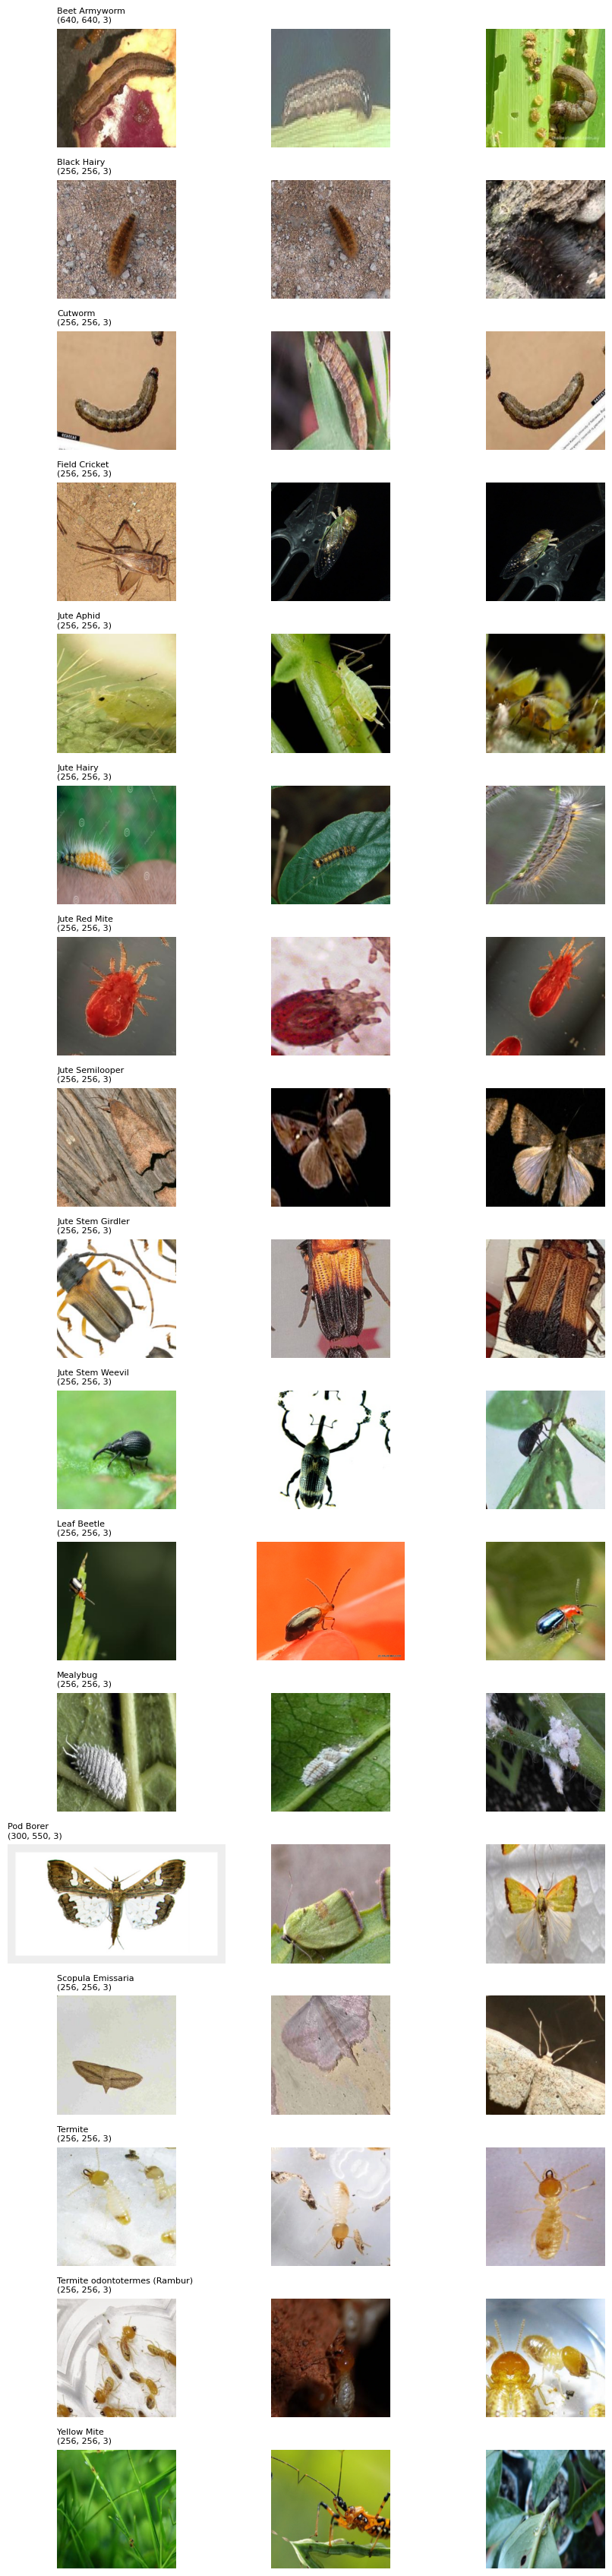

In [ ]:
def plot_sample_images(data_path, class_names, samples_per_class=3):
    n_classes = len(class_names)
    fig, axes = plt.subplots(n_classes, samples_per_class,
                            figsize=(samples_per_class*3, n_classes*2))

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        images = os.listdir(class_path)[:samples_per_class]

        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f"{class_name}\n{img.shape}",
                                    fontsize=8, loc='left')

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'sample_images.png'), dpi=300, bbox_inches='tight')
    plt.show()

plot_sample_images(TRAIN_PATH, class_names, samples_per_class=3)

### 1b(i) + (ii) One-Hot Encoding and Image Resizing

In [ ]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess(path, label, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    if augment:
        img = gpu_augmentation(img, training=True)

    return img, label


def df_to_tf_dataset(df, class_names, augment=False, shuffle=False):
    class_to_idx = {c: i for i, c in enumerate(class_names)}

    labels = df["class_name"].map(class_to_idx).values
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(class_names))

    ds = tf.data.Dataset.from_tensor_slices((df["filename"].values, labels))

    ds = ds.map(
        lambda x, y: load_and_preprocess(x, y, augment),
        num_parallel_calls=AUTOTUNE,
    )

    if shuffle:
        ds = ds.shuffle(buffer_size=1024, seed=SEED)


    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

## 1(c) Transfer Learning



### 1(c)(ii) Image Augmentation for Empirical Regularization  
###(Note: Image augmentation was performed prior to model preprocessing; therefore, Section 1(c)(ii) is presented before Section 1(c)(i). Section 1(c)(i) follows next.)

In [ ]:
import random
from pathlib import Path
def stratified_split_paths(data_dir, val_frac=0.2, seed=42, exts=(".jpg", ".jpeg", ".png", ".bmp")):
    rng = random.Random(seed)
    data_dir = Path(data_dir)

    class_names = sorted([p.name for p in data_dir.iterdir() if p.is_dir()])

    train_rows = []
    val_rows = []

    for class_name in class_names:
        class_dir = data_dir / class_name
        files = [str(p) for p in class_dir.rglob("*") if p.suffix.lower() in exts]
        if not files:
            continue

        rng.shuffle(files)
        n_val = max(1, int(round(len(files) * val_frac)))

        val_files = files[:n_val]
        train_files = files[n_val:]

        val_rows.extend([{"filename": f, "class_name": class_name} for f in val_files])
        train_rows.extend([{"filename": f, "class_name": class_name} for f in train_files])

    train_df = pd.DataFrame(train_rows).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    val_df = pd.DataFrame(val_rows)

    return train_df, val_df, class_names



CROP_SCALE = 1.10

gpu_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Resizing(int(IMAGE_SIZE[0] * CROP_SCALE), int(IMAGE_SIZE[1] * CROP_SCALE)),
        tf.keras.layers.RandomCrop(IMAGE_SIZE[0], IMAGE_SIZE[1]),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.1),
    ],
    name="gpu_augmentation",
)

def get_generators_for_model(model_name):

    train_df, val_df, class_names = stratified_split_paths(
        TRAIN_PATH, val_frac=0.2, seed=SEED
    )


    train_generator = df_to_tf_dataset(
        train_df, class_names, augment=True, shuffle=True
    )


    train_eval_generator = df_to_tf_dataset(
        train_df, class_names, augment=False, shuffle=False
    )


    val_generator = df_to_tf_dataset(
        val_df, class_names, augment=False, shuffle=False
    )


    test_generator = tf.keras.utils.image_dataset_from_directory(
        TEST_PATH,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        label_mode="categorical",
        shuffle=False,
    ).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).prefetch(AUTOTUNE)

    print(f"\nTraining samples:   {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples:       {test_generator.cardinality().numpy() * BATCH_SIZE}")
    print(f"\nClass indices: {dict(zip(class_names, range(len(class_names))))}")

    tv = len(train_df) + len(val_df)
    if tv > 0:
        print(f"Validation split: {len(val_df) / tv * 100:.2f}% of train+val")

    return train_generator, train_eval_generator, val_generator, test_generator

### 1(c)(i) Transfer Learning Using ImageNet Pre-trained Models as Feature Extractors  
### 1(c)(iii) Model Architecture and Training Configuration  
*(Note: These sections are implemented consecutively.)*


In [ ]:
def build_transfer_learning_model(base_model_name, num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=(*IMAGE_SIZE, 3))
    x = layers.Lambda(lambda t: t * 255.0, name="to_255")(inputs)


    if base_model_name in ['ResNet50', 'ResNet101']:
        x = layers.Lambda(resnet_preprocess, name='preprocessing')(x)
    elif base_model_name == 'EfficientNetB0':
        x = layers.Lambda(efficientnet_preprocess, name='preprocessing')(x)
    elif base_model_name == 'VGG16':
        x = layers.Lambda(vgg16_preprocess, name='preprocessing')(x)
    elif base_model_name == 'DenseNet201':
        x = layers.Lambda(densenet_preprocess, name='preprocessing')(x)
    else:
        raise ValueError(f"Unsupported base model: {base_model_name}")


    if base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)
    elif base_model_name == 'ResNet101':
        base_model = ResNet101(weights='imagenet', include_top=False, input_tensor=x)
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=x)
    elif base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=x)
    elif base_model_name == 'DenseNet201':
        base_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=x)

    base_model.trainable = False


    if base_model_name == 'DenseNet201':
        head_units = 256
        l2_reg = 5e-5
        learning_rate = 1e-4
    elif base_model_name == 'EfficientNetB0':
        head_units = 64
        l2_reg = 2e-4
        learning_rate = 1e-3
    else:
        head_units = 128
        l2_reg = 2e-4
        learning_rate = 1e-3


    x = base_model.output
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(
        head_units,
        activation='relu',
        kernel_regularizer=l2(l2_reg),
        name='fc_relu'
    )(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(
        num_classes,
        activation='softmax',
        kernel_regularizer=l2(l2_reg),
        name='output'
    )(x)

    model = Model(inputs=inputs, outputs=outputs, name=base_model_name)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
def get_callbacks(model_name):

    callbacks = [
        ModelCheckpoint(
            filepath=os.path.join(WEIGHTS_PATH, f'{model_name}_best.weights.h5'),
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min',
            restore_best_weights=True,
            verbose=1
        )
    ]
    return callbacks

def train_model(model, model_name, epochs=EPOCHS):



    train_gen, train_eval_gen, val_gen, test_gen = get_generators_for_model(model_name)



    callbacks = get_callbacks(model_name)

    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )


    np.save(os.path.join(RESULTS_PATH, f'{model_name}_history.npy'), history.history)

    return history

print("Training functions created successfully")

Training functions created successfully


In [ ]:
def plot_training_history(history, model_name):

    if hasattr(history, 'history'):
        history = history.history

    epochs_range = range(1, len(history['loss']) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))


    axes[0].plot(
        epochs_range,
        history['loss'],
        label='Training Loss',
        linewidth=2
    )
    axes[0].plot(
        epochs_range,
        history['val_loss'],
        label='Validation Loss',
        linewidth=2
    )
    axes[0].set_title(
        f'{model_name} - Training and Validation Error vs Epochs',
        fontsize=14,
        fontweight='bold'
    )
    axes[0].set_xlabel('Epochs', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)


    axes[1].plot(
        epochs_range,
        history['accuracy'],
        label='Training Accuracy',
        linewidth=2
    )
    axes[1].plot(
        epochs_range,
        history['val_accuracy'],
        label='Validation Accuracy',
        linewidth=2
    )
    axes[1].set_title(
        f'{model_name} - Training and Validation Accuracy vs Epochs',
        fontsize=14,
        fontweight='bold'
    )
    axes[1].set_xlabel('Epochs', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(
        os.path.join(RESULTS_PATH, f'{model_name}_training_history.png'),
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()

print("Plotting functions created successfully")

Plotting functions created successfully


In [ ]:
def evaluate_model(model, dataset, set_name='Test'):

    y_true_list = []
    y_pred_proba_list = []


    for x_batch, y_batch in dataset:
        probs = model.predict(x_batch, verbose=0)
        y_pred_proba_list.append(probs)
        y_true_list.append(y_batch.numpy())

    y_true = np.vstack(y_true_list)
    y_pred_proba = np.vstack(y_pred_proba_list)

    y_true_labels = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred_proba, axis=1)


    accuracy = accuracy_score(y_true_labels, y_pred)
    precision = precision_score(
        y_true_labels, y_pred, average='weighted', zero_division=0
    )
    recall = recall_score(
        y_true_labels, y_pred, average='weighted', zero_division=0
    )
    f1 = f1_score(
        y_true_labels, y_pred, average='weighted', zero_division=0
    )


    try:
        auc_score = roc_auc_score(
            y_true_labels,
            y_pred_proba,
            multi_class='ovr',
            average='weighted'
        )
    except Exception:
        auc_score = 0.0

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc_score,
        'y_true': y_true_labels,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    return metrics

def print_evaluation_results(metrics, model_name, set_name):

    print("="*80)
    print(f"{model_name} - {set_name} Set Results")
    print("="*80)
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1_score']:.4f}")
    print(f"AUC:       {metrics['auc']:.4f}")
    print("="*80)
    print("\nClassification Report:")
    print(classification_report(metrics['y_true'], metrics['y_pred'],
                               target_names=class_names, zero_division=0))

def plot_confusion_matrix(y_true, y_pred, model_name, set_name):

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'{model_name} - {set_name} Set Confusion Matrix',
             fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, f'{model_name}_{set_name}_confusion_matrix.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

print("Evaluation functions created successfully")

Evaluation functions created successfully


### 1(c)iv. Training the Models
### Training ResNet50

Building and Training ResNet50 Model

Total parameters: 23,860,369
Trainable parameters: 268,561
Found 379 files belonging to 17 classes.

Training samples:   5156
Validation samples: 1287
Test samples:       384

Class indices: {'Beet Armyworm': 0, 'Black Hairy': 1, 'Cutworm': 2, 'Field Cricket': 3, 'Jute Aphid': 4, 'Jute Hairy': 5, 'Jute Red Mite': 6, 'Jute Semilooper': 7, 'Jute Stem Girdler': 8, 'Jute Stem Weevil': 9, 'Leaf Beetle': 10, 'Mealybug': 11, 'Pod Borer': 12, 'Scopula Emissaria': 13, 'Termite': 14, 'Termite odontotermes (Rambur)': 15, 'Yellow Mite': 16}
Validation split: 19.98% of train+val
Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6546 - loss: 1.2676
Epoch 1: val_loss improved from inf to 0.26844, saving model to /content/drive/MyDrive/DSCI552-MahinMohan/weights/ResNet50_best.weights.h5
162/162 ━━━━━━━━━━━━━━━━━━━━ 44s 173ms/step - accuracy: 0.6555 - loss: 1.2642 - val_accuracy: 0.9340 - val_loss: 0.2684
Epoch 2/50
159/162 ━━━━━━━━━━━━━━━━━━━━ 0s

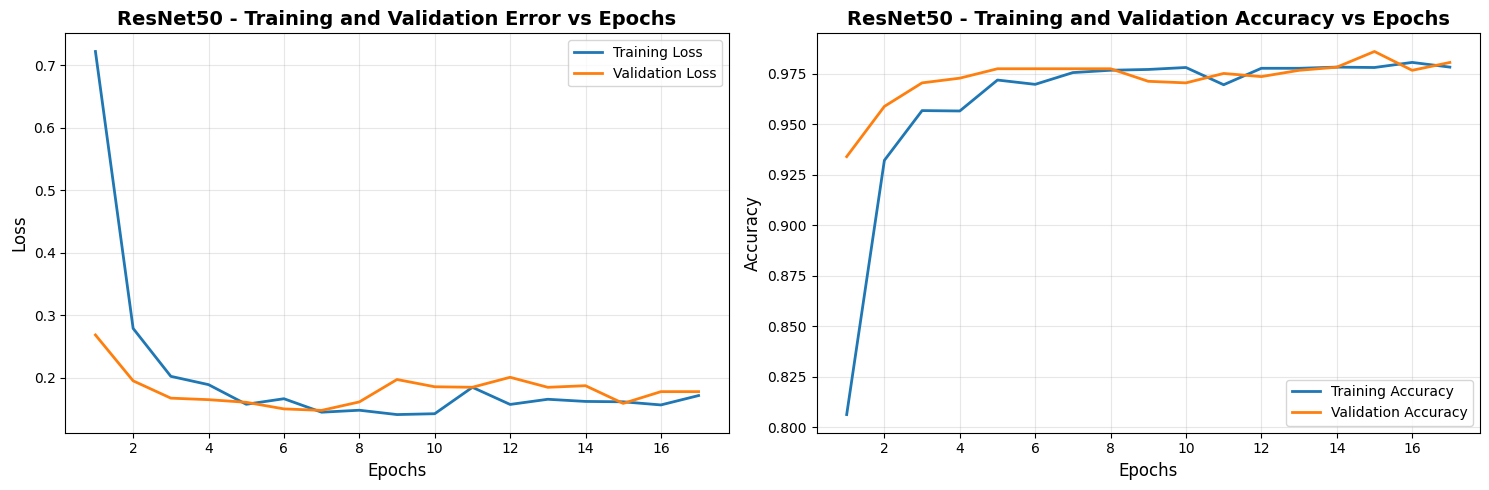

In [ ]:

print('='*80)
print(f'Building and Training ResNet50 Model')
print('='*80)

model_resnet50 = build_transfer_learning_model('ResNet50')
print(f'\nTotal parameters: {model_resnet50.count_params():,}')
print(f'Trainable parameters: {sum([tf.size(w).numpy() for w in model_resnet50.trainable_weights]):,}')


history_resnet50 = train_model(
    model_resnet50,
    'ResNet50',
    epochs=EPOCHS
)


plot_training_history(history_resnet50, 'ResNet50')

### Training ResNet101

Building and Training ResNet101 Model

Total parameters: 42,930,833
Trainable parameters: 268,561
Found 379 files belonging to 17 classes.

Training samples:   5156
Validation samples: 1287
Test samples:       384

Class indices: {'Beet Armyworm': 0, 'Black Hairy': 1, 'Cutworm': 2, 'Field Cricket': 3, 'Jute Aphid': 4, 'Jute Hairy': 5, 'Jute Red Mite': 6, 'Jute Semilooper': 7, 'Jute Stem Girdler': 8, 'Jute Stem Weevil': 9, 'Leaf Beetle': 10, 'Mealybug': 11, 'Pod Borer': 12, 'Scopula Emissaria': 13, 'Termite': 14, 'Termite odontotermes (Rambur)': 15, 'Yellow Mite': 16}
Validation split: 19.98% of train+val
Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6738 - loss: 1.2173
Epoch 1: val_loss improved from inf to 0.24531, saving model to /content/drive/MyDrive/DSCI552-MahinMohan/weights/ResNet101_best.weights.h5
162/162 ━━━━━━━━━━━━━━━━━━━━ 59s 215ms/step - accuracy: 0.6746 - loss: 1.2141 - val_accuracy: 0.9487 - val_loss: 0.2453
Epoch 2/50
161/162 ━━━━━━━━━━━━━━━━━━━━ 

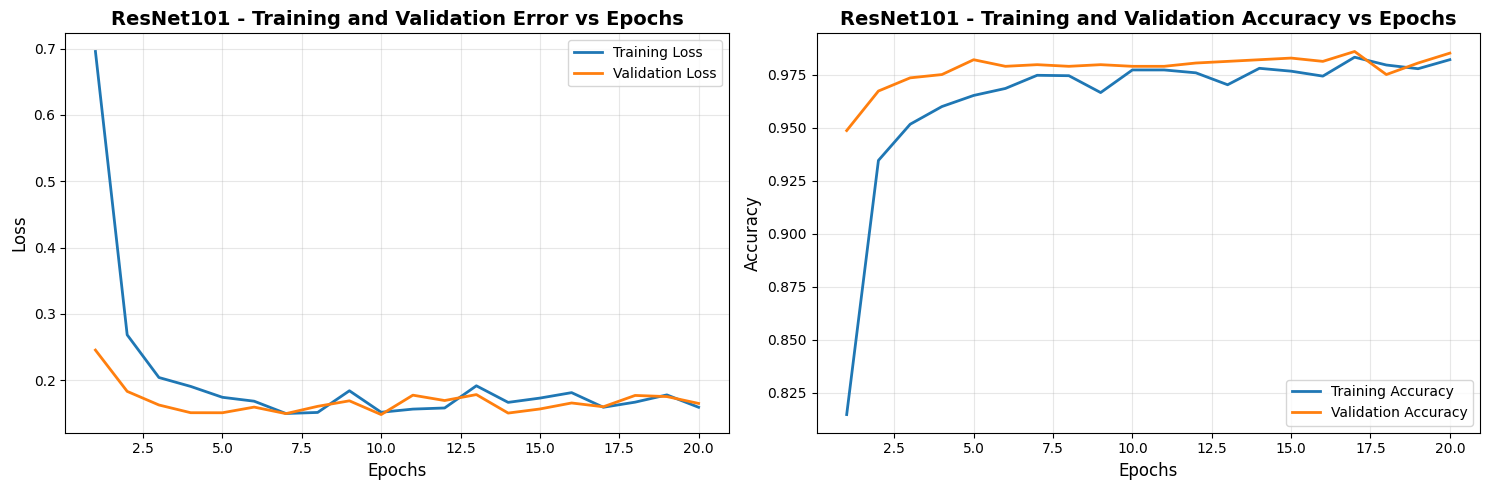

In [ ]:

print('='*80)
print(f'Building and Training ResNet101 Model')
print('='*80)

model_resnet101 = build_transfer_learning_model('ResNet101')
print(f'\nTotal parameters: {model_resnet101.count_params():,}')
print(f'Trainable parameters: {sum([tf.size(w).numpy() for w in model_resnet101.trainable_weights]):,}')


history_resnet101 = train_model(
    model_resnet101,
    'ResNet101',
    epochs=EPOCHS
)


plot_training_history(history_resnet101, 'ResNet101')

### Training EfficientNetB0

Building and Training EfficientNetB0 Model

Total parameters: 4,137,780
Trainable parameters: 85,649
Found 379 files belonging to 17 classes.

Training samples:   5156
Validation samples: 1287
Test samples:       384

Class indices: {'Beet Armyworm': 0, 'Black Hairy': 1, 'Cutworm': 2, 'Field Cricket': 3, 'Jute Aphid': 4, 'Jute Hairy': 5, 'Jute Red Mite': 6, 'Jute Semilooper': 7, 'Jute Stem Girdler': 8, 'Jute Stem Weevil': 9, 'Leaf Beetle': 10, 'Mealybug': 11, 'Pod Borer': 12, 'Scopula Emissaria': 13, 'Termite': 14, 'Termite odontotermes (Rambur)': 15, 'Yellow Mite': 16}
Validation split: 19.98% of train+val
Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5584 - loss: 1.4890
Epoch 1: val_loss improved from inf to 0.39310, saving model to /content/drive/MyDrive/DSCI552-MahinMohan/weights/EfficientNetB0_best.weights.h5
162/162 ━━━━━━━━━━━━━━━━━━━━ 64s 238ms/step - accuracy: 0.5594 - loss: 1.4854 - val_accuracy: 0.9340 - val_loss: 0.3931
Epoch 2/50
159/162 ━━━━━━━━━━━━━

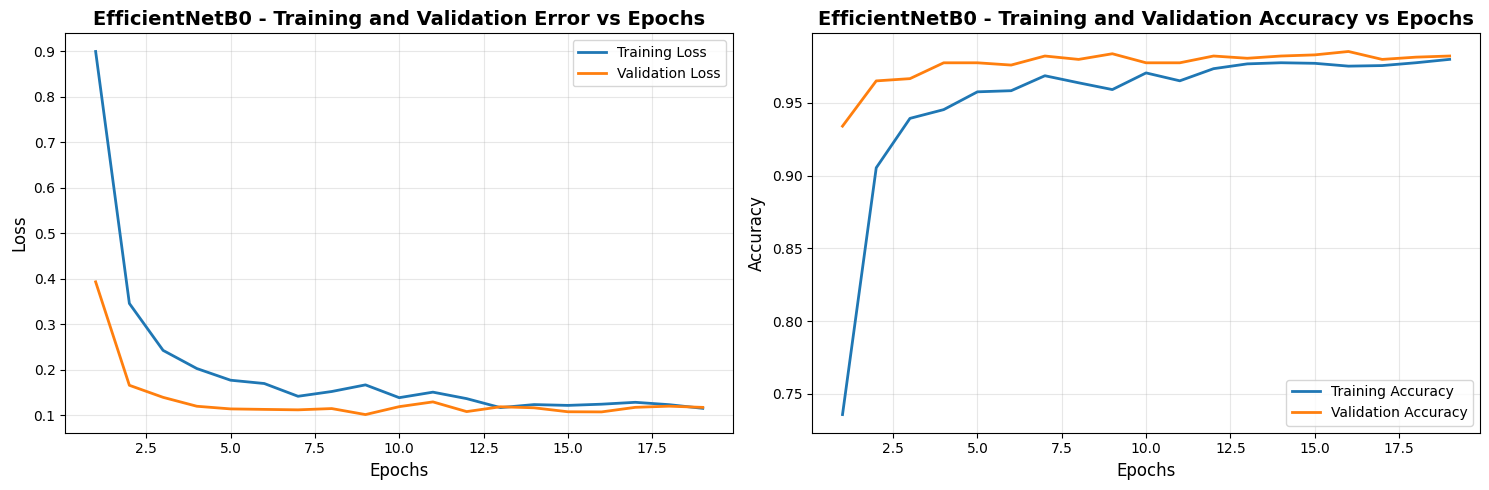

In [ ]:

print('='*80)
print(f'Building and Training EfficientNetB0 Model')
print('='*80)

model_efficientnetb0 = build_transfer_learning_model('EfficientNetB0')
print(f'\nTotal parameters: {model_efficientnetb0.count_params():,}')
print(f'Trainable parameters: {sum([tf.size(w).numpy() for w in model_efficientnetb0.trainable_weights]):,}')


history_efficientnetb0 = train_model(
    model_efficientnetb0,
    'EfficientNetB0',
    epochs=EPOCHS
)


plot_training_history(history_efficientnetb0, 'EfficientNetB0')

### Training VGG16

Building and Training VGG16 Model

Total parameters: 14,784,593
Trainable parameters: 68,881
Found 379 files belonging to 17 classes.

Training samples:   5156
Validation samples: 1287
Test samples:       384

Class indices: {'Beet Armyworm': 0, 'Black Hairy': 1, 'Cutworm': 2, 'Field Cricket': 3, 'Jute Aphid': 4, 'Jute Hairy': 5, 'Jute Red Mite': 6, 'Jute Semilooper': 7, 'Jute Stem Girdler': 8, 'Jute Stem Weevil': 9, 'Leaf Beetle': 10, 'Mealybug': 11, 'Pod Borer': 12, 'Scopula Emissaria': 13, 'Termite': 14, 'Termite odontotermes (Rambur)': 15, 'Yellow Mite': 16}
Validation split: 19.98% of train+val
Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4608 - loss: 1.9043
Epoch 1: val_loss improved from inf to 0.45124, saving model to /content/drive/MyDrive/DSCI552-MahinMohan/weights/VGG16_best.weights.h5
162/162 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - accuracy: 0.4619 - loss: 1.9003 - val_accuracy: 0.8772 - val_loss: 0.4512
Epoch 2/50
159/162 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/st

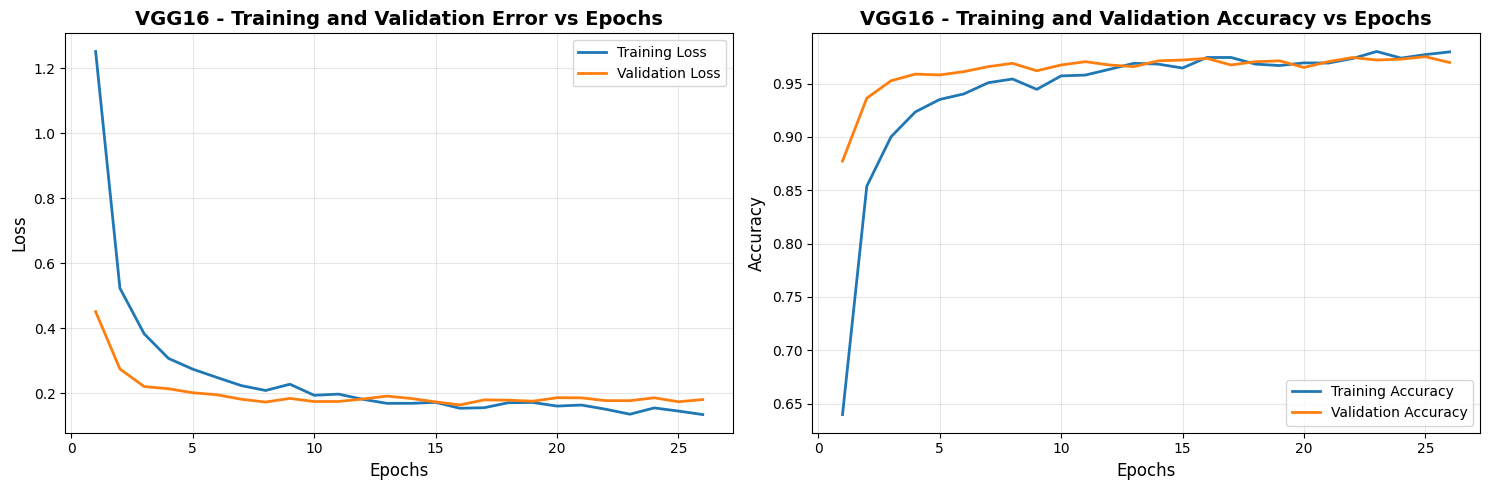

In [ ]:

print('='*80)
print(f'Building and Training VGG16 Model')
print('='*80)

model_vgg16 = build_transfer_learning_model('VGG16')
print(f'\nTotal parameters: {model_vgg16.count_params():,}')
print(f'Trainable parameters: {sum([tf.size(w).numpy() for w in model_vgg16.trainable_weights]):,}')


history_vgg16 = train_model(
    model_vgg16,
    'VGG16',
    epochs=EPOCHS
)


plot_training_history(history_vgg16, 'VGG16')

### Training DenseNet201

Building and Training DenseNet201 Model

Total parameters: 18,825,809
Trainable parameters: 499,985
Found 379 files belonging to 17 classes.

Training samples:   5156
Validation samples: 1287
Test samples:       384

Class indices: {'Beet Armyworm': 0, 'Black Hairy': 1, 'Cutworm': 2, 'Field Cricket': 3, 'Jute Aphid': 4, 'Jute Hairy': 5, 'Jute Red Mite': 6, 'Jute Semilooper': 7, 'Jute Stem Girdler': 8, 'Jute Stem Weevil': 9, 'Leaf Beetle': 10, 'Mealybug': 11, 'Pod Borer': 12, 'Scopula Emissaria': 13, 'Termite': 14, 'Termite odontotermes (Rambur)': 15, 'Yellow Mite': 16}
Validation split: 19.98% of train+val
Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.3024 - loss: 2.4012
Epoch 1: val_loss improved from inf to 1.05460, saving model to /content/drive/MyDrive/DSCI552-MahinMohan/weights/DenseNet201_best.weights.h5
162/162 ━━━━━━━━━━━━━━━━━━━━ 143s 559ms/step - accuracy: 0.3036 - loss: 2.3976 - val_accuracy: 0.7700 - val_loss: 1.0546
Epoch 2/50
161/162 ━━━━━━━━━━━━━━━━

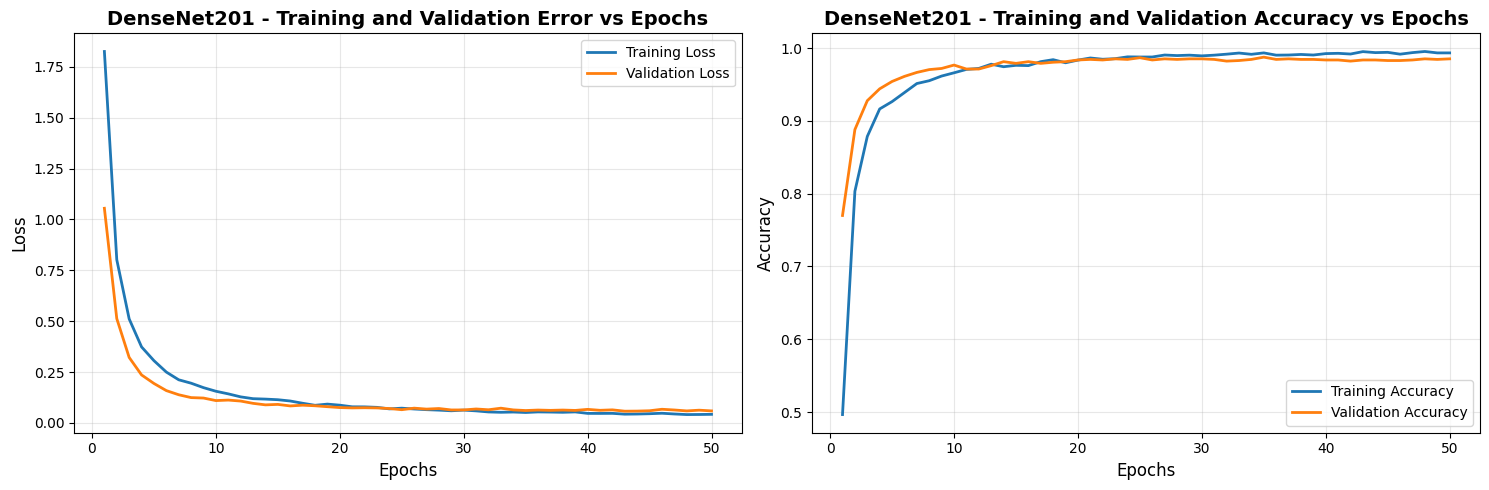

In [ ]:

print('='*80)
print(f'Building and Training DenseNet201 Model')
print('='*80)

model_densenet201 = build_transfer_learning_model('DenseNet201')
print(f'\nTotal parameters: {model_densenet201.count_params():,}')
print(f'Trainable parameters: {sum([tf.size(w).numpy() for w in model_densenet201.trainable_weights]):,}')


history_densenet201 = train_model(
    model_densenet201,
    'DenseNet201',
    epochs=EPOCHS
)


plot_training_history(history_densenet201, 'DenseNet201')

## 1(c)v. Report training, validation, and test Precision, Recall, AUC, and F1 score for those models. Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem.

In [ ]:

all_results = {}


model_names_list = ['ResNet50', 'ResNet101', 'EfficientNetB0', 'VGG16', 'DenseNet201']
models_dict = {
    'ResNet50': model_resnet50,
    'ResNet101': model_resnet101,
    'EfficientNetB0': model_efficientnetb0,
    'VGG16': model_vgg16,
    'DenseNet201': model_densenet201
}


for model_name in model_names_list:
    print(f'\n{"="*80}')
    print(f'Evaluating {model_name} with model-specific preprocessing')
    print(f'{"="*80}')
    all_results[model_name] = {}


    models_dict[model_name].load_weights(
        os.path.join(WEIGHTS_PATH, f'{model_name}_best.weights.h5')
    )


    _, train_eval_gen, val_gen, test_gen = get_generators_for_model(model_name)
    print(f"Using {model_name}-specific preprocessing for evaluation")


    all_results[model_name]['train'] = evaluate_model(
        models_dict[model_name], train_eval_gen, 'Train'
    )


    all_results[model_name]['val'] = evaluate_model(
        models_dict[model_name], val_gen, 'Validation'
    )


    all_results[model_name]['test'] = evaluate_model(
        models_dict[model_name], test_gen, 'Test'
    )


Evaluating ResNet50 with model-specific preprocessing
Found 379 files belonging to 17 classes.

Training samples:   5156
Validation samples: 1287
Test samples:       384

Class indices: {'Beet Armyworm': 0, 'Black Hairy': 1, 'Cutworm': 2, 'Field Cricket': 3, 'Jute Aphid': 4, 'Jute Hairy': 5, 'Jute Red Mite': 6, 'Jute Semilooper': 7, 'Jute Stem Girdler': 8, 'Jute Stem Weevil': 9, 'Leaf Beetle': 10, 'Mealybug': 11, 'Pod Borer': 12, 'Scopula Emissaria': 13, 'Termite': 14, 'Termite odontotermes (Rambur)': 15, 'Yellow Mite': 16}
Validation split: 19.98% of train+val
Using ResNet50-specific preprocessing for evaluation

Evaluating ResNet101 with model-specific preprocessing
Found 379 files belonging to 17 classes.

Training samples:   5156
Validation samples: 1287
Test samples:       384

Class indices: {'Beet Armyworm': 0, 'Black Hairy': 1, 'Cutworm': 2, 'Field Cricket': 3, 'Jute Aphid': 4, 'Jute Hairy': 5, 'Jute Red Mite': 6, 'Jute Semilooper': 7, 'Jute Stem Girdler': 8, 'Jute Stem Weevil

### ResNet50 Results

ResNet50 - Training Set Results
Accuracy:  0.9936
Precision: 0.9937
Recall:    0.9936
F1-Score:  0.9936
AUC:       1.0000

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.98      0.97      0.97       159
                  Black Hairy       0.96      1.00      0.98       247
                      Cutworm       0.99      1.00      1.00       319
                Field Cricket       1.00      1.00      1.00       314
                   Jute Aphid       0.97      0.99      0.98       424
                   Jute Hairy       1.00      0.98      0.99       331
                Jute Red Mite       1.00      1.00      1.00       366
              Jute Semilooper       1.00      1.00      1.00       298
            Jute Stem Girdler       1.00      1.00      1.00       225
             Jute Stem Weevil       1.00      0.99      0.99       541
                  Leaf Beetle       0.99      1.00      1.00       248
 

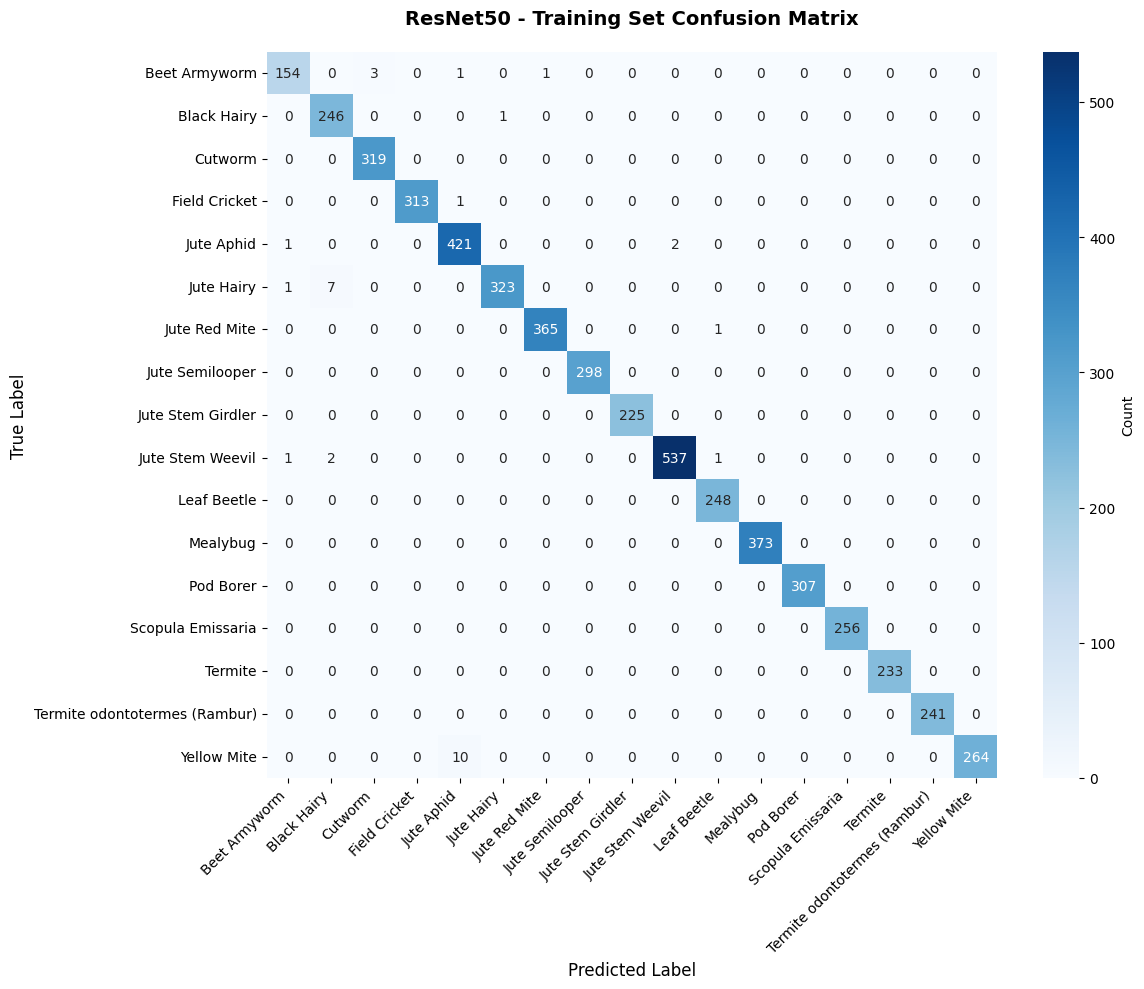

ResNet50 - Validation Set Results
Accuracy:  0.9775
Precision: 0.9779
Recall:    0.9775
F1-Score:  0.9774
AUC:       0.9996

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.87      0.82      0.85        40
                  Black Hairy       0.97      0.98      0.98        62
                      Cutworm       0.97      0.96      0.97        80
                Field Cricket       1.00      0.99      0.99        78
                   Jute Aphid       0.91      0.97      0.94       106
                   Jute Hairy       0.96      0.99      0.98        83
                Jute Red Mite       1.00      0.99      0.99        91
              Jute Semilooper       1.00      1.00      1.00        74
            Jute Stem Girdler       1.00      1.00      1.00        56
             Jute Stem Weevil       0.97      1.00      0.99       135
                  Leaf Beetle       0.97      1.00      0.98        62

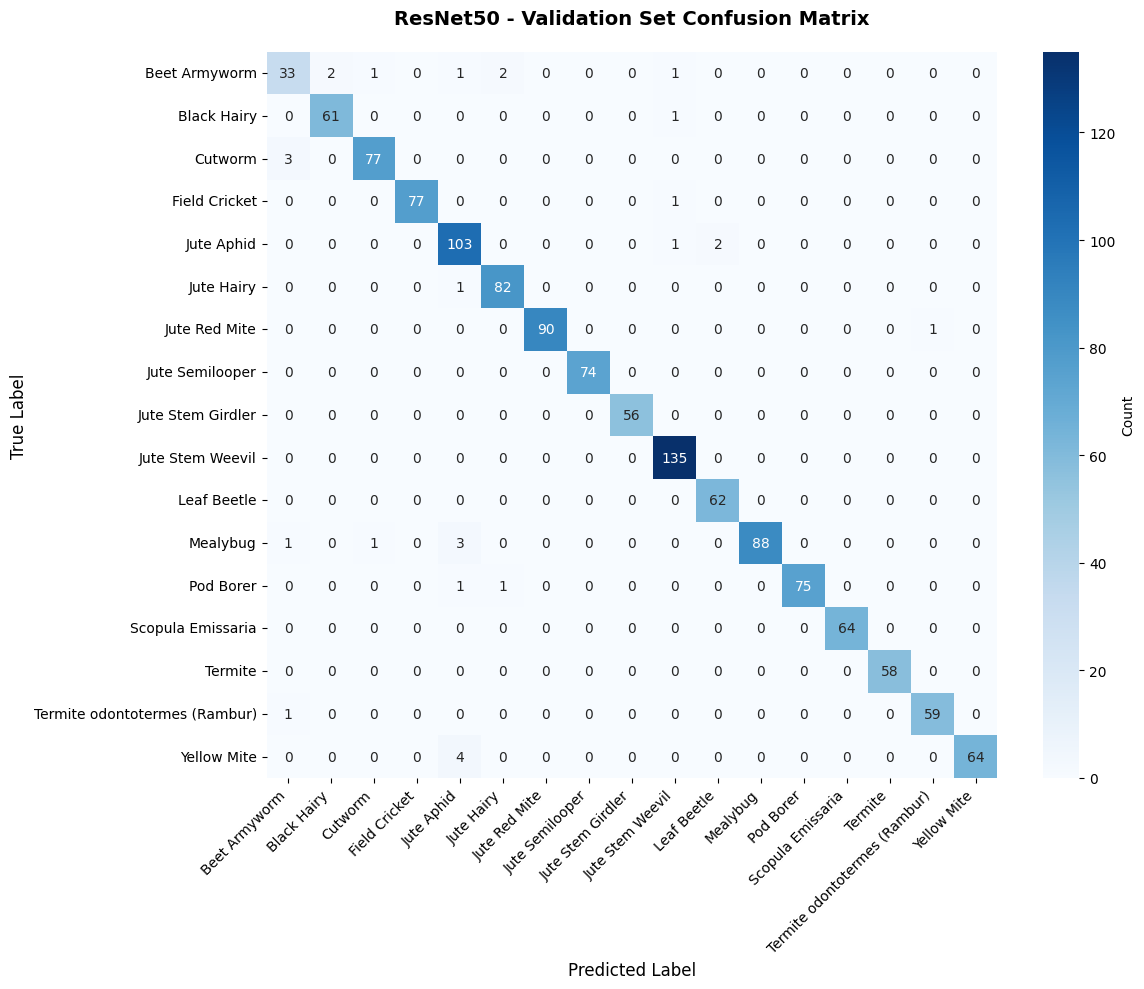

ResNet50 - Test Set Results
Accuracy:  0.9736
Precision: 0.9755
Recall:    0.9736
F1-Score:  0.9737
AUC:       0.9997

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.95      0.90      0.92        20
                  Black Hairy       1.00      1.00      1.00        20
                      Cutworm       0.95      1.00      0.98        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       0.85      1.00      0.92        22
                   Jute Hairy       0.91      1.00      0.95        20
                Jute Red Mite       0.96      0.96      0.96        24
              Jute Semilooper       1.00      0.95      0.98        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      0.96      0.98        24
                  Leaf Beetle       1.00      1.00      1.00        24
     

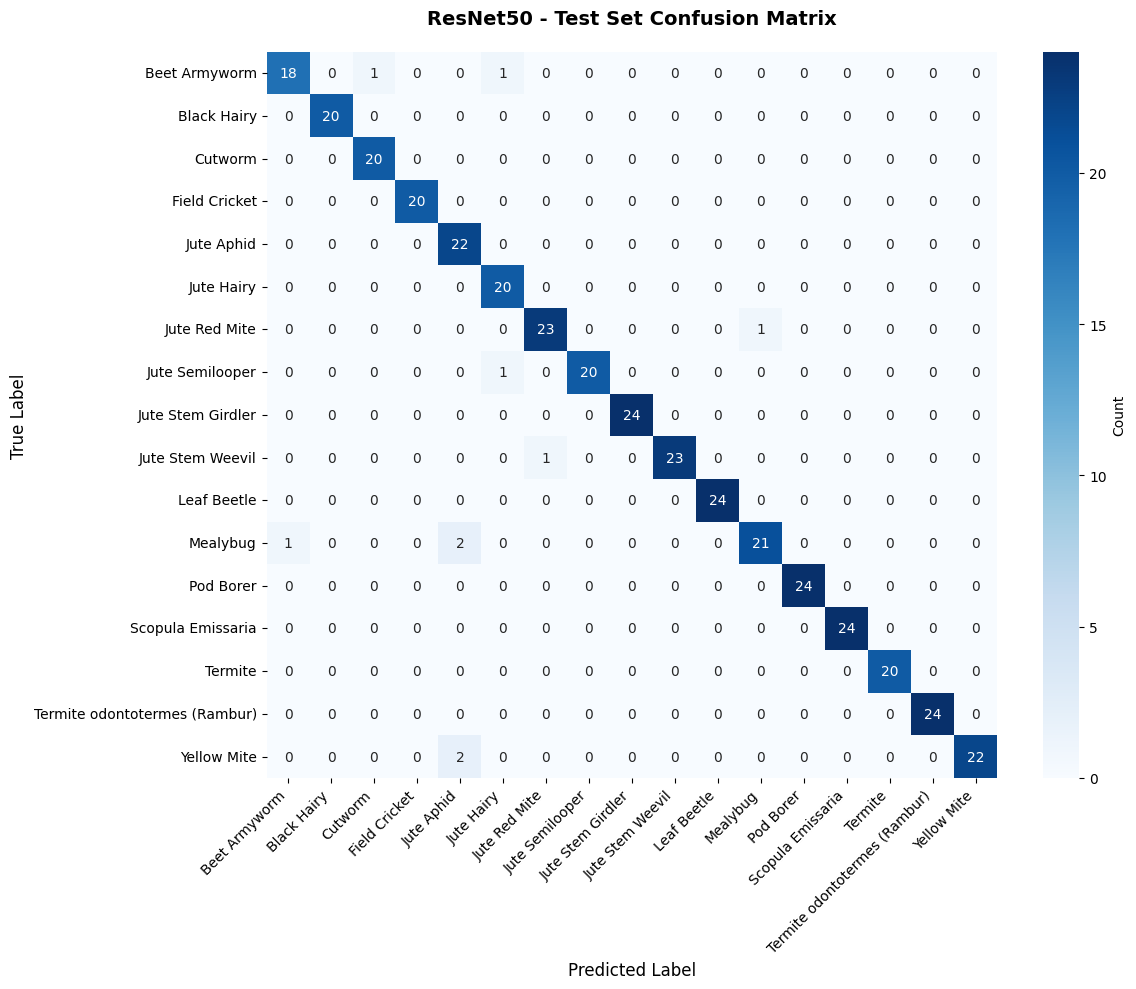

In [ ]:

print_evaluation_results(all_results['ResNet50']['train'], 'ResNet50', 'Training')
plot_confusion_matrix(
    all_results['ResNet50']['train']['y_true'],
    all_results['ResNet50']['train']['y_pred'],
    'ResNet50', 'Training'
)


print_evaluation_results(all_results['ResNet50']['val'], 'ResNet50', 'Validation')
plot_confusion_matrix(
    all_results['ResNet50']['val']['y_true'],
    all_results['ResNet50']['val']['y_pred'],
    'ResNet50', 'Validation'
)


print_evaluation_results(all_results['ResNet50']['test'], 'ResNet50', 'Test')
plot_confusion_matrix(
    all_results['ResNet50']['test']['y_true'],
    all_results['ResNet50']['test']['y_pred'],
    'ResNet50', 'Test'
)

### ResNet101 Results

ResNet101 - Training Set Results
Accuracy:  0.9942
Precision: 0.9942
Recall:    0.9942
F1-Score:  0.9942
AUC:       1.0000

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.98      0.97      0.98       159
                  Black Hairy       1.00      0.97      0.99       247
                      Cutworm       0.99      0.99      0.99       319
                Field Cricket       1.00      1.00      1.00       314
                   Jute Aphid       0.98      0.99      0.98       424
                   Jute Hairy       0.98      0.99      0.98       331
                Jute Red Mite       1.00      1.00      1.00       366
              Jute Semilooper       1.00      1.00      1.00       298
            Jute Stem Girdler       1.00      1.00      1.00       225
             Jute Stem Weevil       1.00      1.00      1.00       541
                  Leaf Beetle       1.00      1.00      1.00       248


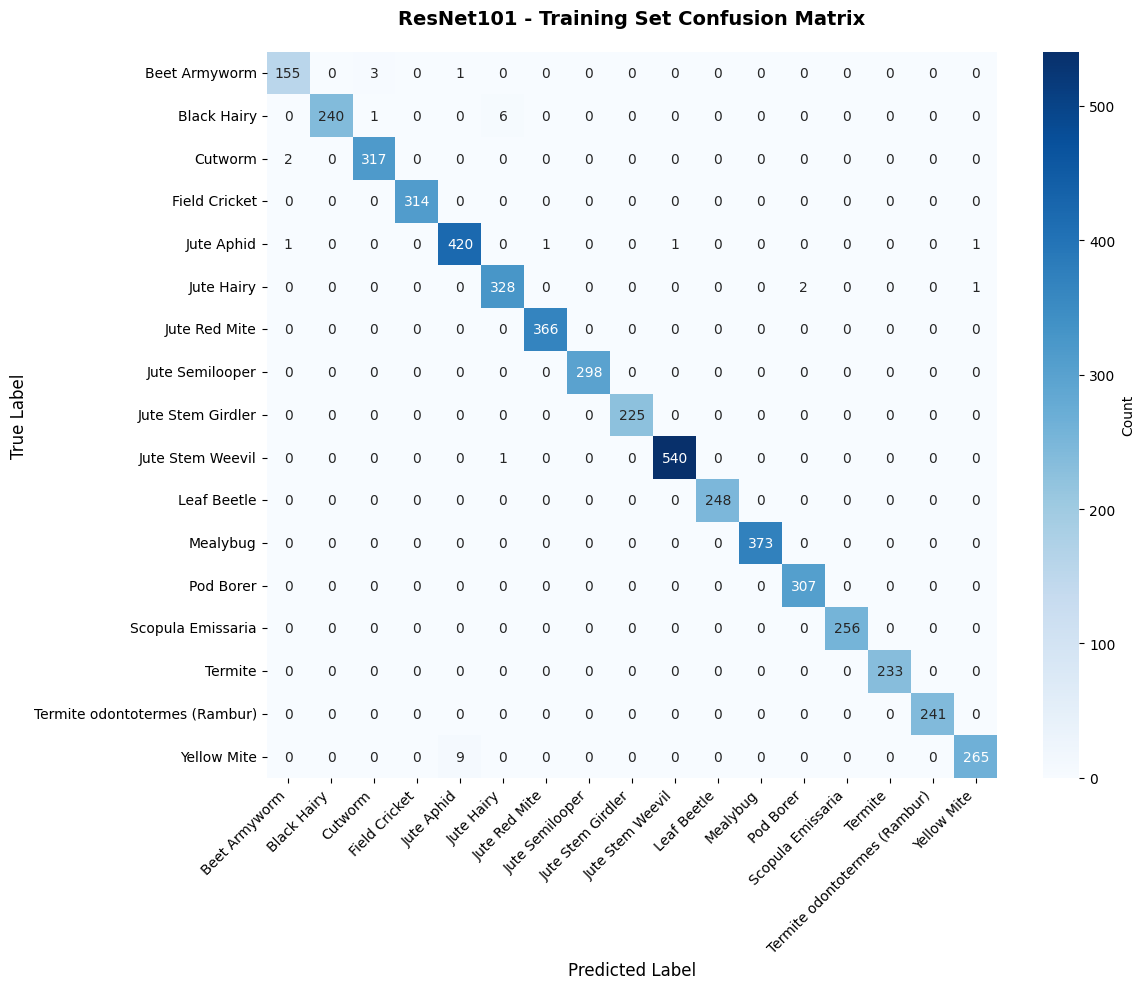

ResNet101 - Validation Set Results
Accuracy:  0.9790
Precision: 0.9794
Recall:    0.9790
F1-Score:  0.9788
AUC:       0.9998

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.97      0.85      0.91        40
                  Black Hairy       0.97      0.90      0.93        62
                      Cutworm       0.96      0.97      0.97        80
                Field Cricket       1.00      1.00      1.00        78
                   Jute Aphid       0.95      0.99      0.97       106
                   Jute Hairy       0.92      0.98      0.95        83
                Jute Red Mite       0.99      1.00      0.99        91
              Jute Semilooper       0.99      1.00      0.99        74
            Jute Stem Girdler       1.00      1.00      1.00        56
             Jute Stem Weevil       0.99      0.99      0.99       135
                  Leaf Beetle       1.00      1.00      1.00        6

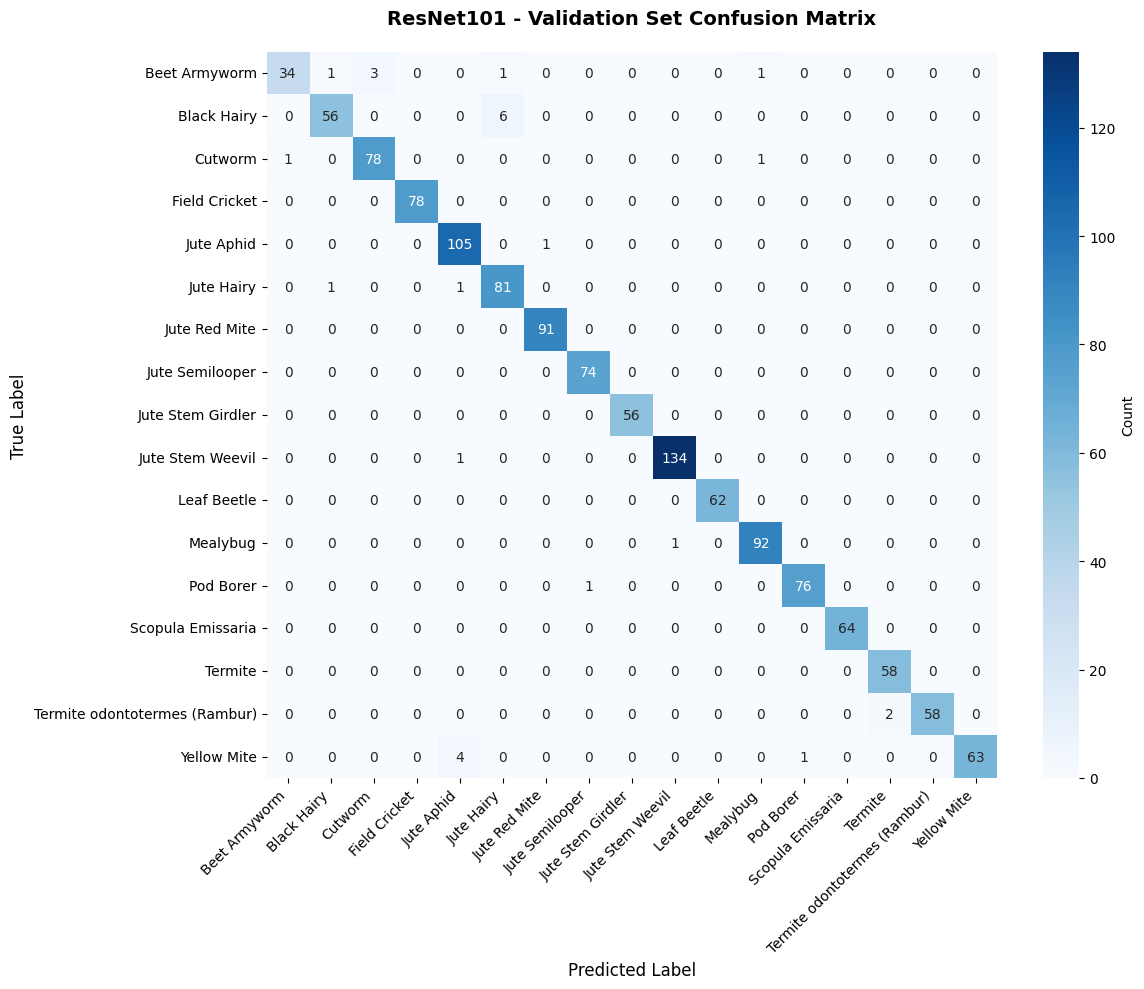

ResNet101 - Test Set Results
Accuracy:  0.9710
Precision: 0.9740
Recall:    0.9710
F1-Score:  0.9707
AUC:       0.9997

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       1.00      0.75      0.86        20
                  Black Hairy       1.00      1.00      1.00        20
                      Cutworm       0.91      1.00      0.95        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       0.85      1.00      0.92        22
                   Jute Hairy       0.86      0.95      0.90        20
                Jute Red Mite       1.00      0.96      0.98        24
              Jute Semilooper       1.00      0.95      0.98        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24
    

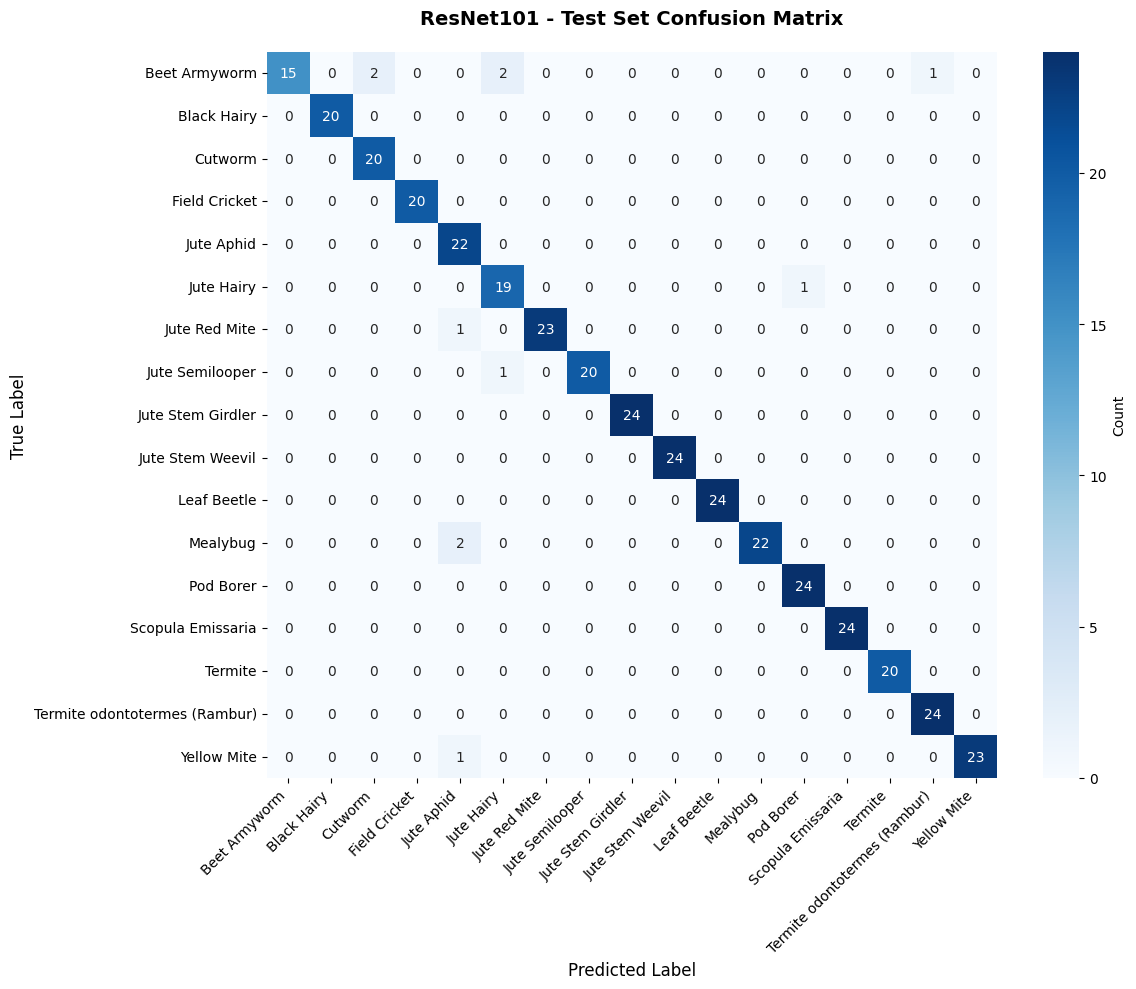

In [ ]:

print_evaluation_results(all_results['ResNet101']['train'], 'ResNet101', 'Training')
plot_confusion_matrix(
    all_results['ResNet101']['train']['y_true'],
    all_results['ResNet101']['train']['y_pred'],
    'ResNet101', 'Training'
)


print_evaluation_results(all_results['ResNet101']['val'], 'ResNet101', 'Validation')
plot_confusion_matrix(
    all_results['ResNet101']['val']['y_true'],
    all_results['ResNet101']['val']['y_pred'],
    'ResNet101', 'Validation'
)


print_evaluation_results(all_results['ResNet101']['test'], 'ResNet101', 'Test')
plot_confusion_matrix(
    all_results['ResNet101']['test']['y_true'],
    all_results['ResNet101']['test']['y_pred'],
    'ResNet101', 'Test'
)

### EfficientNetB0 Results

EfficientNetB0 - Training Set Results
Accuracy:  0.9919
Precision: 0.9920
Recall:    0.9919
F1-Score:  0.9919
AUC:       1.0000

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.96      0.99      0.98       159
                  Black Hairy       0.99      0.98      0.98       247
                      Cutworm       1.00      0.99      0.99       319
                Field Cricket       1.00      1.00      1.00       314
                   Jute Aphid       0.96      0.99      0.98       424
                   Jute Hairy       0.98      0.97      0.97       331
                Jute Red Mite       1.00      1.00      1.00       366
              Jute Semilooper       0.99      1.00      0.99       298
            Jute Stem Girdler       1.00      1.00      1.00       225
             Jute Stem Weevil       1.00      0.99      0.99       541
                  Leaf Beetle       1.00      1.00      1.00      

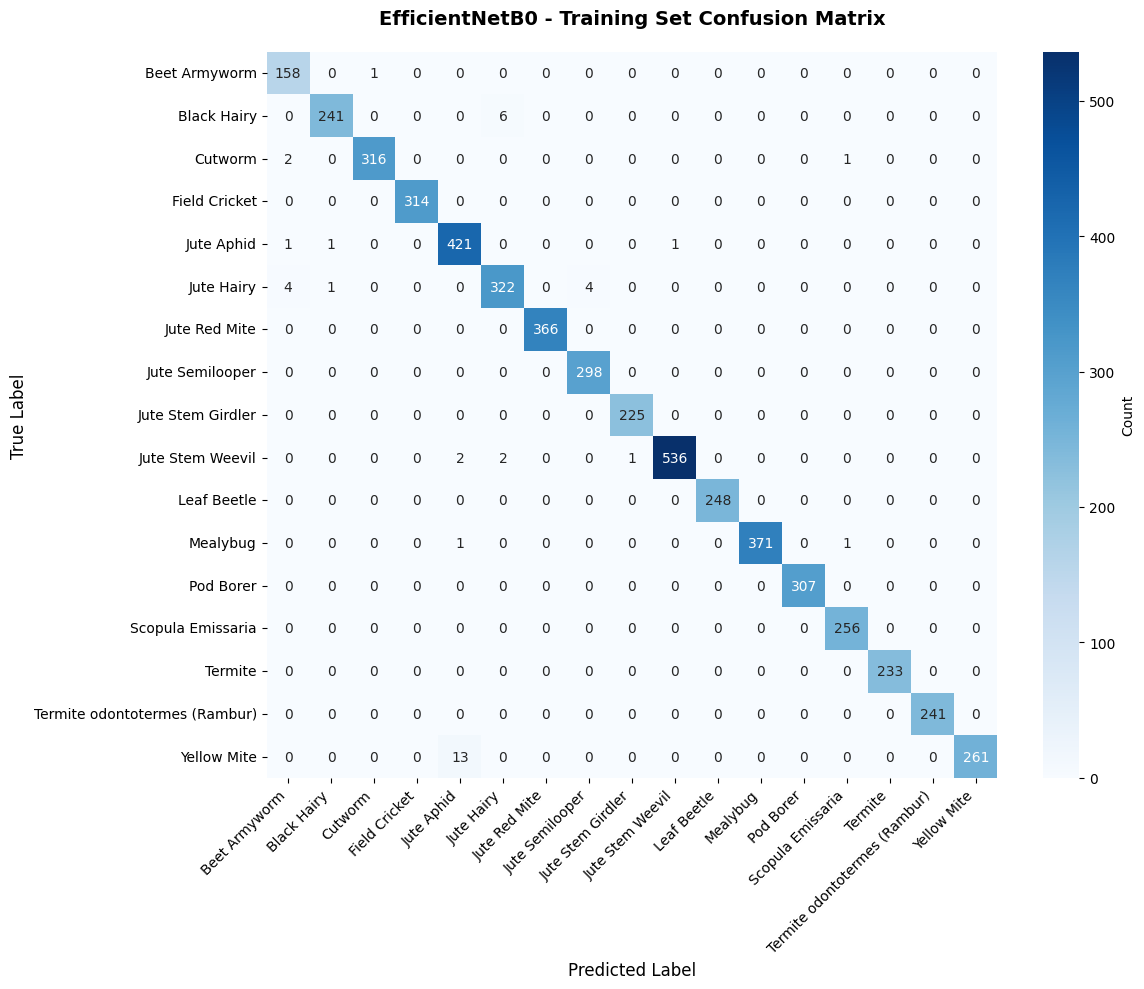

EfficientNetB0 - Validation Set Results
Accuracy:  0.9837
Precision: 0.9840
Recall:    0.9837
F1-Score:  0.9837
AUC:       0.9997

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.93      0.93      0.93        40
                  Black Hairy       0.98      0.92      0.95        62
                      Cutworm       0.96      0.96      0.96        80
                Field Cricket       1.00      1.00      1.00        78
                   Jute Aphid       0.95      0.97      0.96       106
                   Jute Hairy       0.93      1.00      0.97        83
                Jute Red Mite       0.99      1.00      0.99        91
              Jute Semilooper       1.00      1.00      1.00        74
            Jute Stem Girdler       1.00      1.00      1.00        56
             Jute Stem Weevil       1.00      0.99      1.00       135
                  Leaf Beetle       1.00      1.00      1.00    

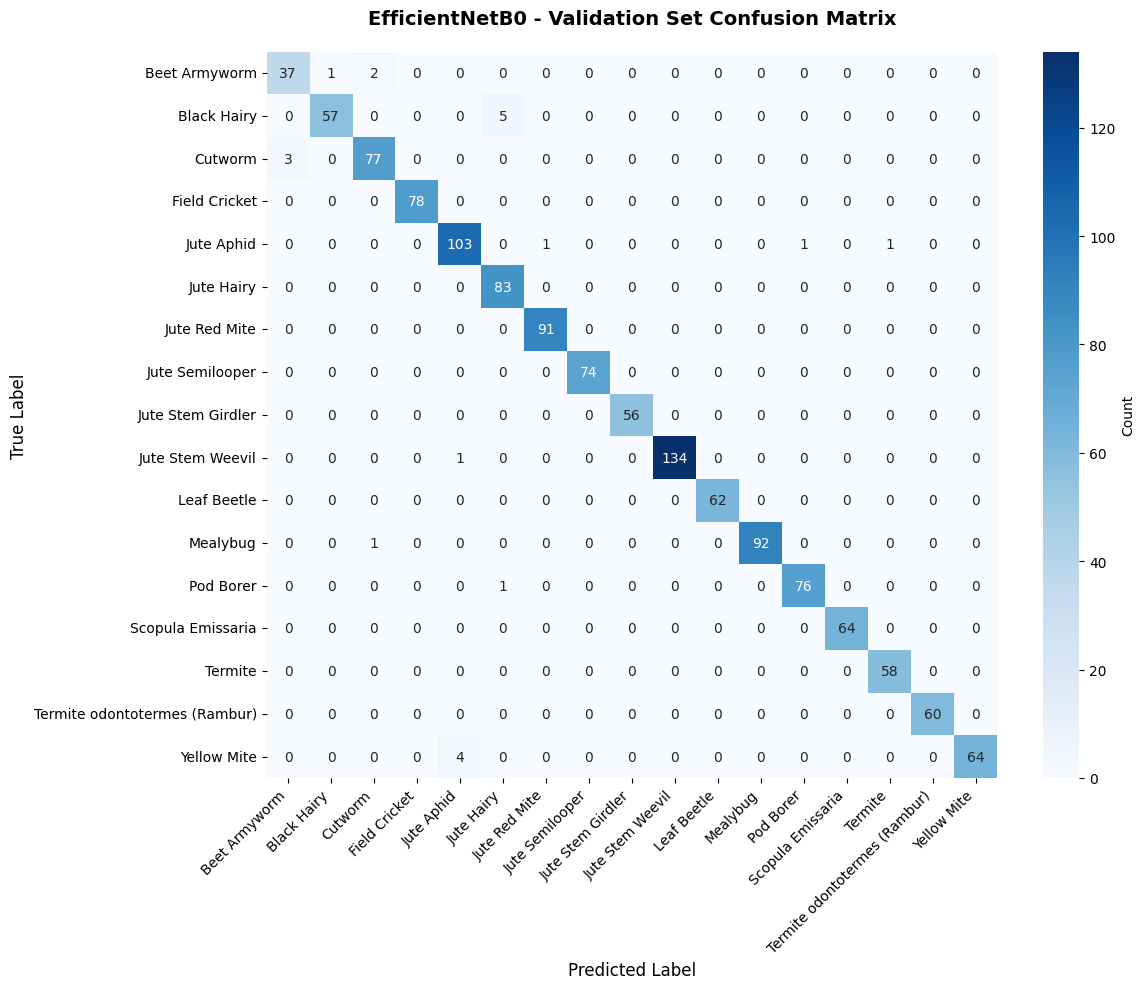

EfficientNetB0 - Test Set Results
Accuracy:  0.9736
Precision: 0.9774
Recall:    0.9736
F1-Score:  0.9741
AUC:       0.9999

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       1.00      0.90      0.95        20
                  Black Hairy       1.00      1.00      1.00        20
                      Cutworm       0.95      1.00      0.98        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       0.79      1.00      0.88        22
                   Jute Hairy       1.00      0.90      0.95        20
                Jute Red Mite       1.00      1.00      1.00        24
              Jute Semilooper       0.91      1.00      0.95        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       1.00      1.00      1.00        24
                  Leaf Beetle       1.00      1.00      1.00        24

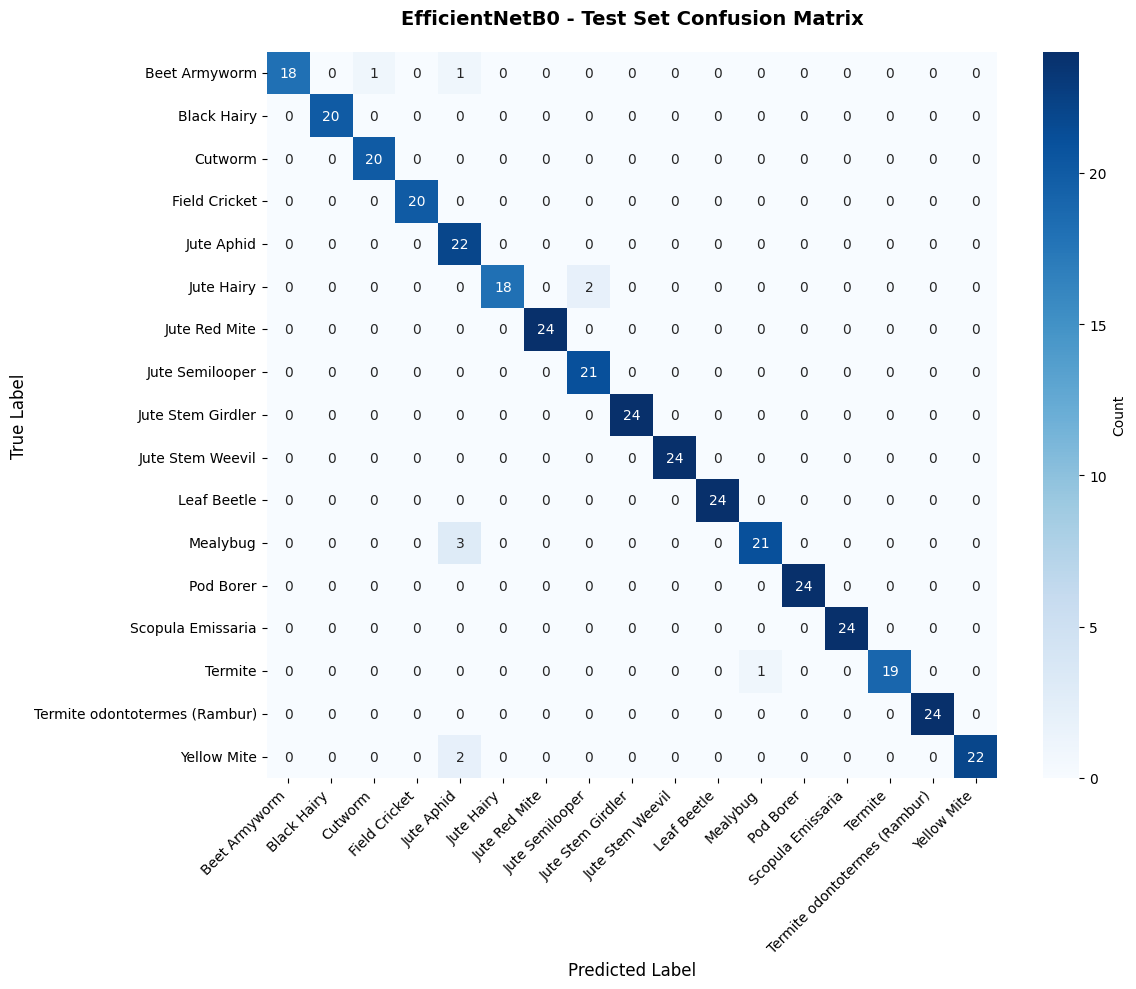

In [ ]:

print_evaluation_results(all_results['EfficientNetB0']['train'], 'EfficientNetB0', 'Training')
plot_confusion_matrix(
    all_results['EfficientNetB0']['train']['y_true'],
    all_results['EfficientNetB0']['train']['y_pred'],
    'EfficientNetB0', 'Training'
)


print_evaluation_results(all_results['EfficientNetB0']['val'], 'EfficientNetB0', 'Validation')
plot_confusion_matrix(
    all_results['EfficientNetB0']['val']['y_true'],
    all_results['EfficientNetB0']['val']['y_pred'],
    'EfficientNetB0', 'Validation'
)


print_evaluation_results(all_results['EfficientNetB0']['test'], 'EfficientNetB0', 'Test')
plot_confusion_matrix(
    all_results['EfficientNetB0']['test']['y_true'],
    all_results['EfficientNetB0']['test']['y_pred'],
    'EfficientNetB0', 'Test'
)

### VGG16 Results

VGG16 - Training Set Results
Accuracy:  0.9913
Precision: 0.9914
Recall:    0.9913
F1-Score:  0.9913
AUC:       1.0000

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.94      0.97      0.96       159
                  Black Hairy       0.95      1.00      0.97       247
                      Cutworm       1.00      0.97      0.99       319
                Field Cricket       0.99      1.00      1.00       314
                   Jute Aphid       0.98      0.98      0.98       424
                   Jute Hairy       1.00      0.97      0.98       331
                Jute Red Mite       1.00      0.99      0.99       366
              Jute Semilooper       1.00      1.00      1.00       298
            Jute Stem Girdler       1.00      1.00      1.00       225
             Jute Stem Weevil       1.00      1.00      1.00       541
                  Leaf Beetle       1.00      1.00      1.00       248
    

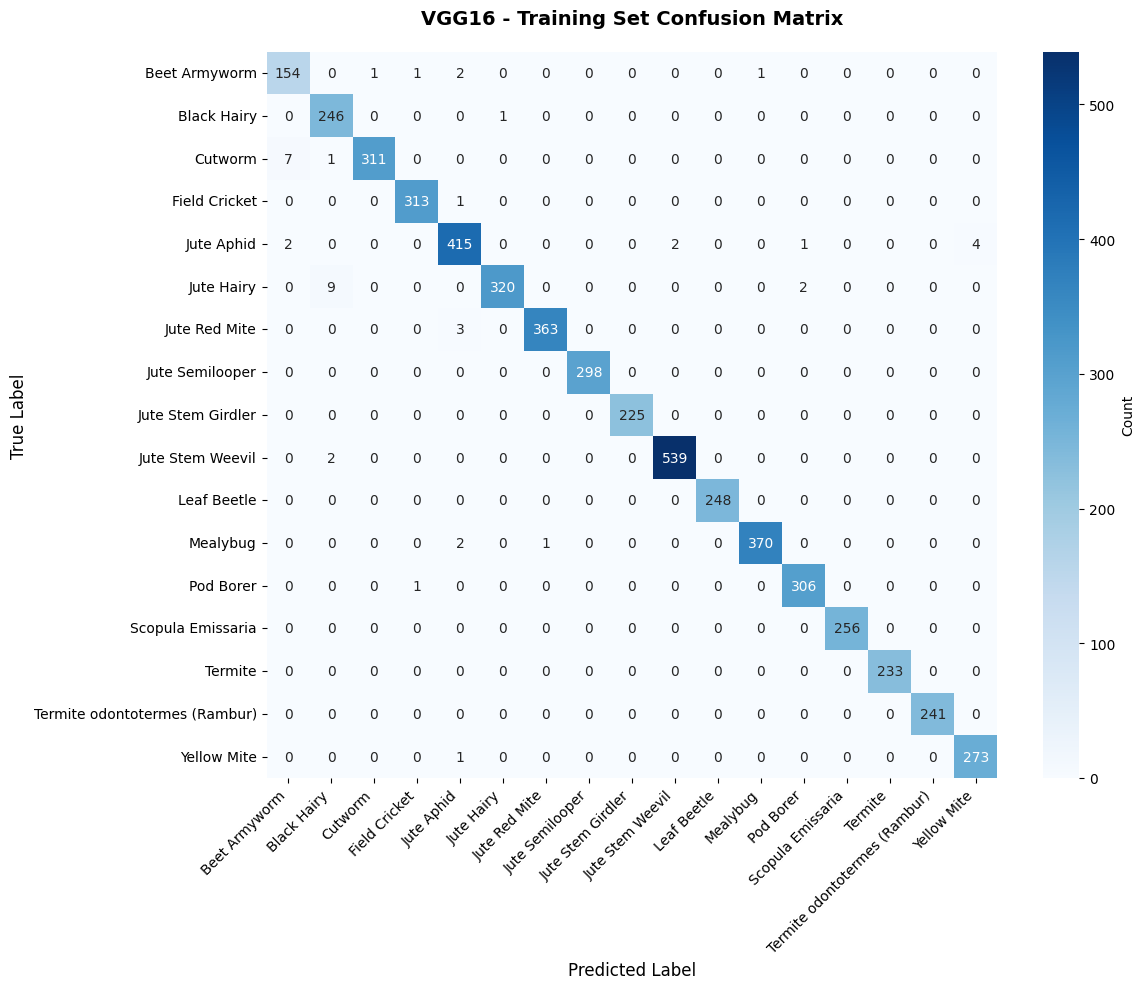

VGG16 - Validation Set Results
Accuracy:  0.9736
Precision: 0.9739
Recall:    0.9736
F1-Score:  0.9734
AUC:       0.9994

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.97      0.80      0.88        40
                  Black Hairy       0.98      0.98      0.98        62
                      Cutworm       0.96      0.95      0.96        80
                Field Cricket       0.97      1.00      0.99        78
                   Jute Aphid       0.91      0.93      0.92       106
                   Jute Hairy       0.93      0.98      0.95        83
                Jute Red Mite       1.00      0.98      0.99        91
              Jute Semilooper       1.00      1.00      1.00        74
            Jute Stem Girdler       1.00      1.00      1.00        56
             Jute Stem Weevil       0.99      0.99      0.99       135
                  Leaf Beetle       1.00      1.00      1.00        62
  

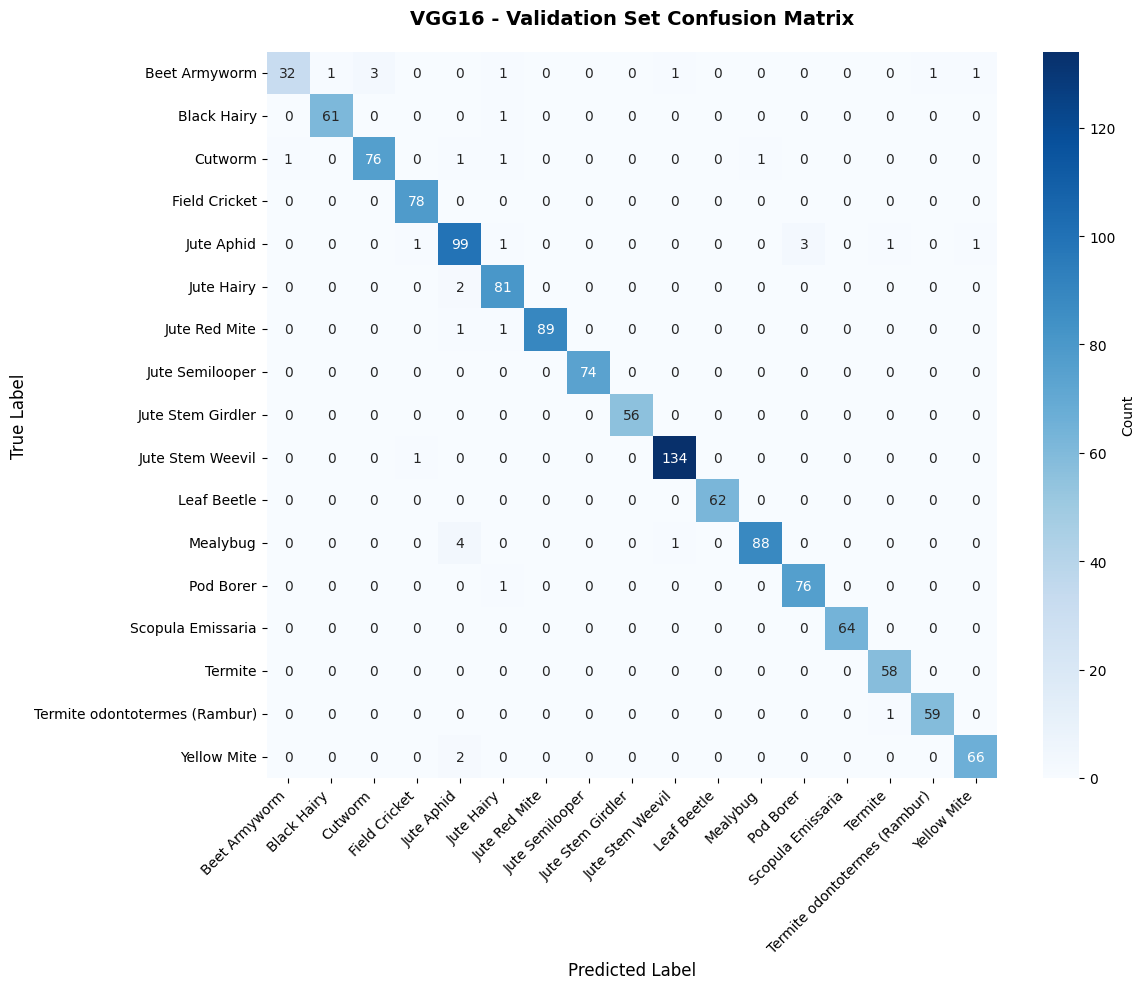

VGG16 - Test Set Results
Accuracy:  0.9736
Precision: 0.9739
Recall:    0.9736
F1-Score:  0.9732
AUC:       0.9997

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.89      0.80      0.84        20
                  Black Hairy       1.00      1.00      1.00        20
                      Cutworm       0.90      0.95      0.93        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       0.96      1.00      0.98        22
                   Jute Hairy       0.95      1.00      0.98        20
                Jute Red Mite       0.92      0.96      0.94        24
              Jute Semilooper       1.00      0.95      0.98        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       0.96      1.00      0.98        24
                  Leaf Beetle       1.00      1.00      1.00        24
        

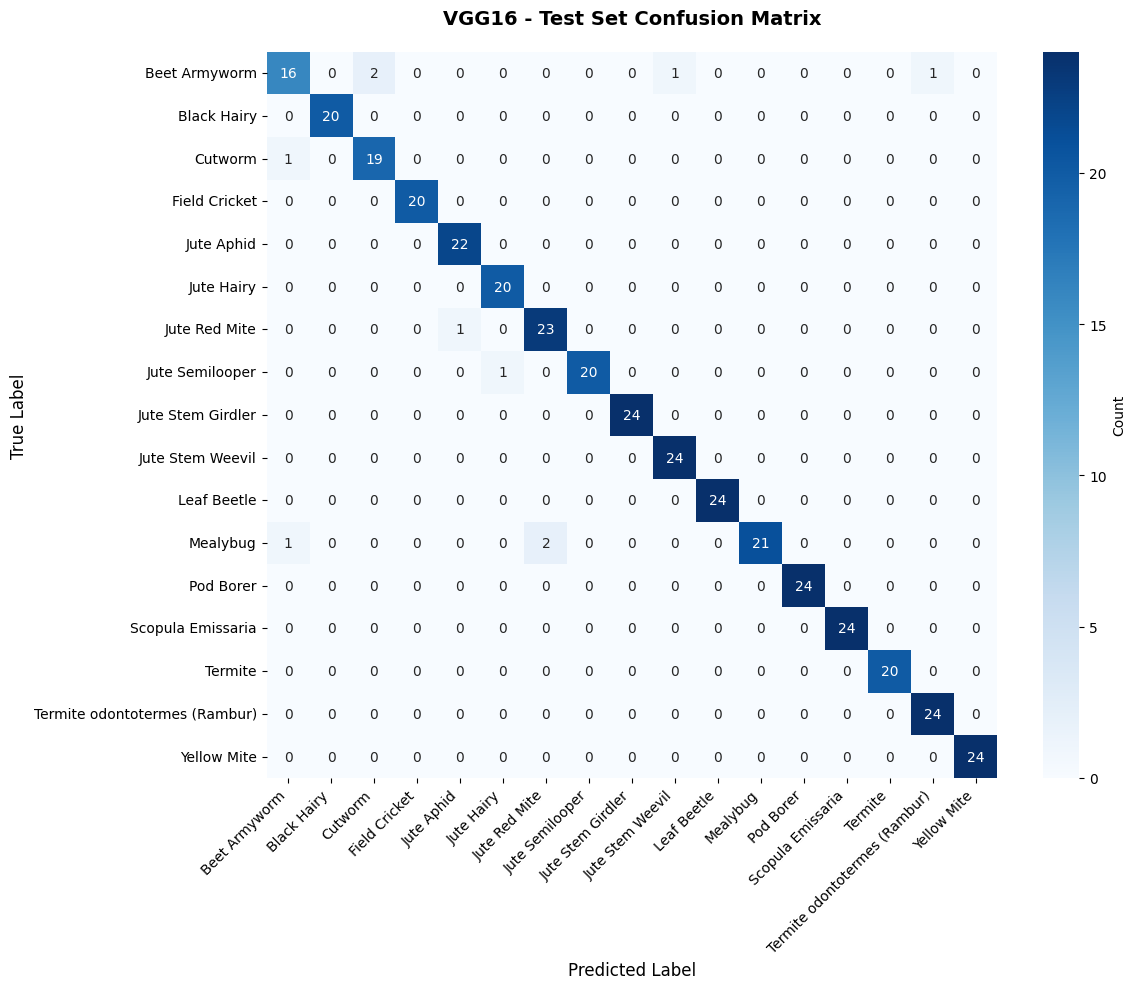

In [ ]:

print_evaluation_results(all_results['VGG16']['train'], 'VGG16', 'Training')
plot_confusion_matrix(
    all_results['VGG16']['train']['y_true'],
    all_results['VGG16']['train']['y_pred'],
    'VGG16', 'Training'
)


print_evaluation_results(all_results['VGG16']['val'], 'VGG16', 'Validation')
plot_confusion_matrix(
    all_results['VGG16']['val']['y_true'],
    all_results['VGG16']['val']['y_pred'],
    'VGG16', 'Validation'
)


print_evaluation_results(all_results['VGG16']['test'], 'VGG16', 'Test')
plot_confusion_matrix(
    all_results['VGG16']['test']['y_true'],
    all_results['VGG16']['test']['y_pred'],
    'VGG16', 'Test'
)

### DenseNet201 Results

DenseNet201 - Training Set Results
Accuracy:  0.9952
Precision: 0.9953
Recall:    0.9952
F1-Score:  0.9952
AUC:       1.0000

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.99      1.00      0.99       159
                  Black Hairy       1.00      0.98      0.99       247
                      Cutworm       1.00      0.99      1.00       319
                Field Cricket       1.00      1.00      1.00       314
                   Jute Aphid       0.97      1.00      0.98       424
                   Jute Hairy       0.98      0.99      0.98       331
                Jute Red Mite       1.00      1.00      1.00       366
              Jute Semilooper       1.00      1.00      1.00       298
            Jute Stem Girdler       1.00      1.00      1.00       225
             Jute Stem Weevil       1.00      1.00      1.00       541
                  Leaf Beetle       1.00      1.00      1.00       24

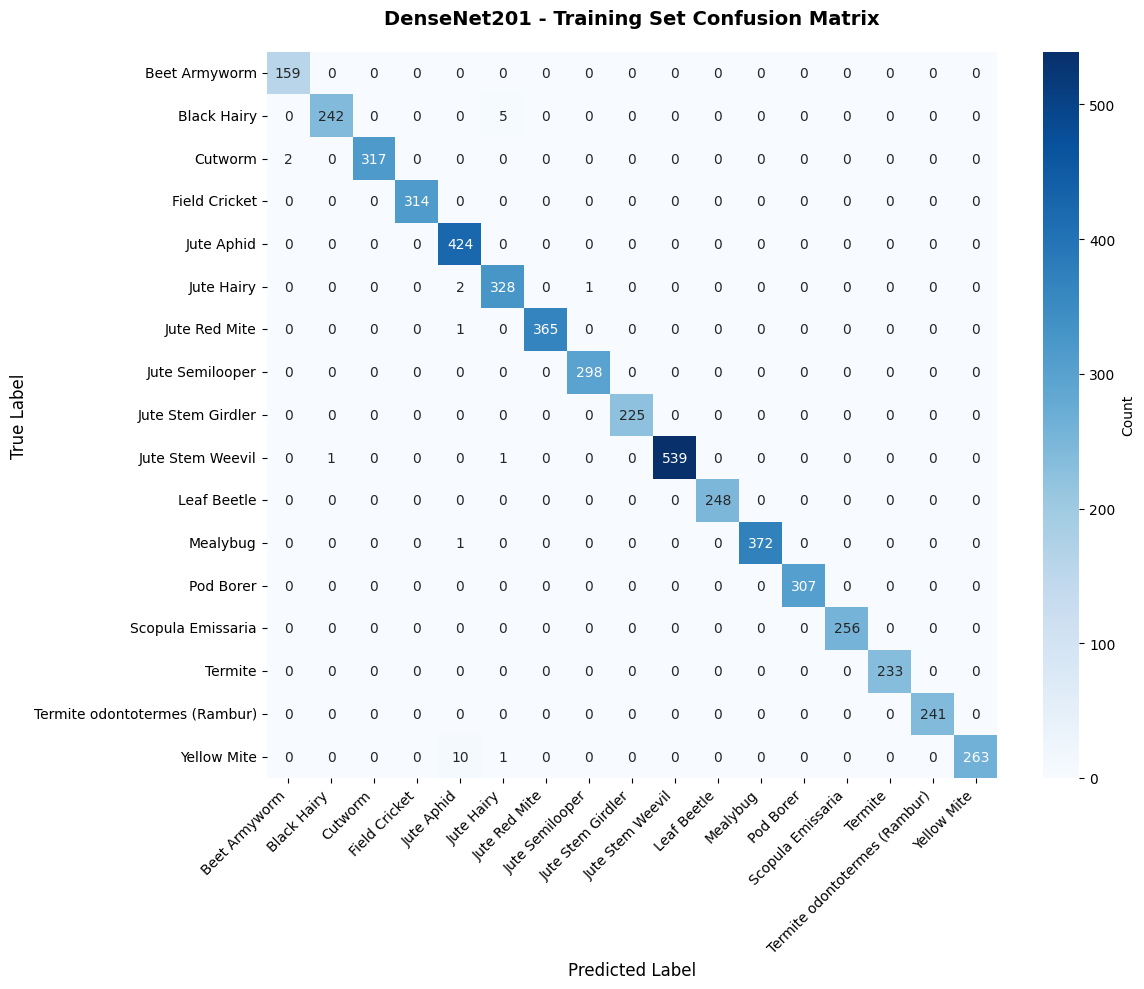

DenseNet201 - Validation Set Results
Accuracy:  0.9837
Precision: 0.9840
Recall:    0.9837
F1-Score:  0.9837
AUC:       0.9999

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.95      0.95      0.95        40
                  Black Hairy       0.98      0.92      0.95        62
                      Cutworm       0.99      0.96      0.97        80
                Field Cricket       1.00      1.00      1.00        78
                   Jute Aphid       0.94      0.97      0.96       106
                   Jute Hairy       0.93      0.99      0.96        83
                Jute Red Mite       0.99      1.00      0.99        91
              Jute Semilooper       1.00      1.00      1.00        74
            Jute Stem Girdler       1.00      1.00      1.00        56
             Jute Stem Weevil       0.99      1.00      0.99       135
                  Leaf Beetle       1.00      1.00      1.00       

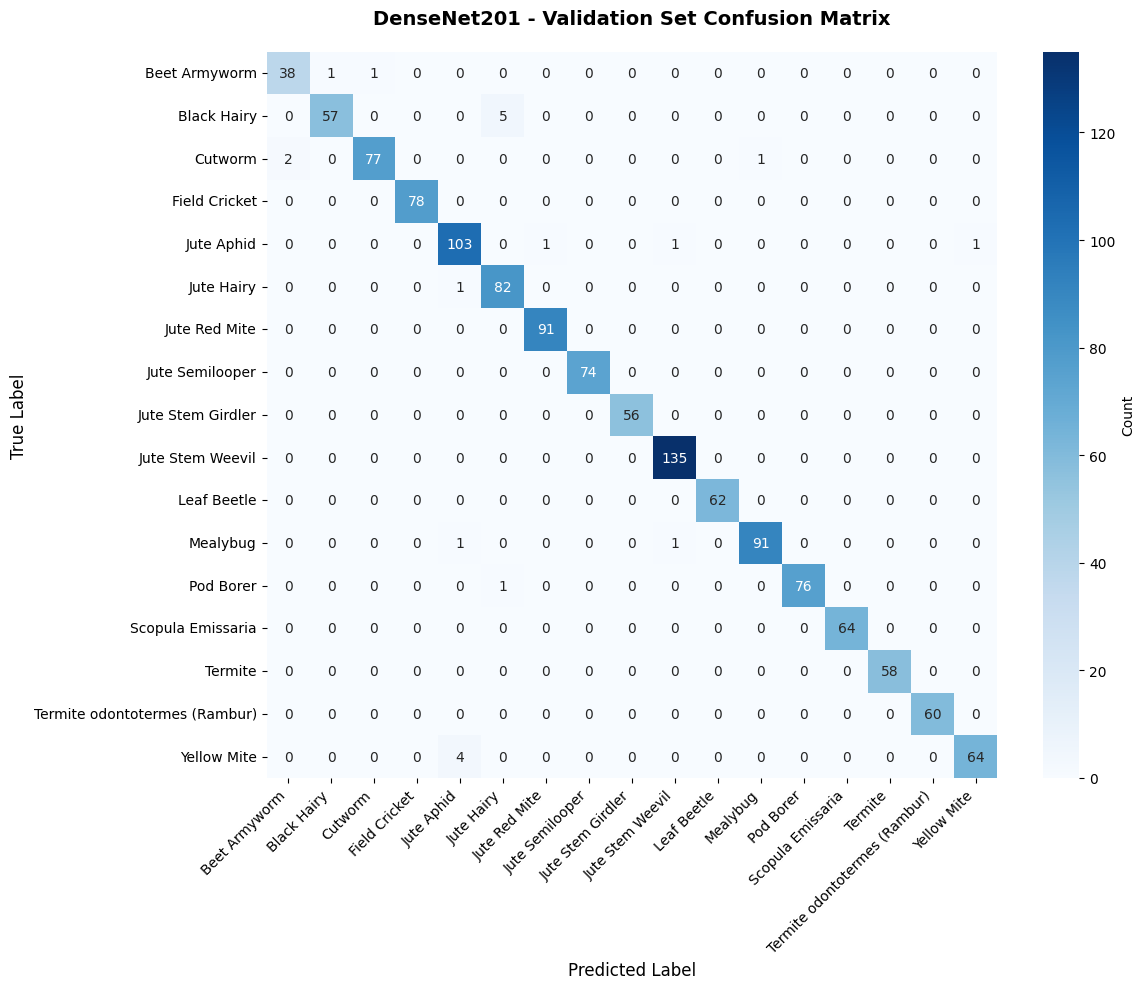

DenseNet201 - Test Set Results
Accuracy:  0.9710
Precision: 0.9738
Recall:    0.9710
F1-Score:  0.9713
AUC:       0.9996

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.95      0.95      0.95        20
                  Black Hairy       1.00      1.00      1.00        20
                      Cutworm       0.95      0.95      0.95        20
                Field Cricket       1.00      1.00      1.00        20
                   Jute Aphid       0.81      1.00      0.90        22
                   Jute Hairy       0.95      0.95      0.95        20
                Jute Red Mite       1.00      0.96      0.98        24
              Jute Semilooper       0.91      0.95      0.93        21
            Jute Stem Girdler       1.00      1.00      1.00        24
             Jute Stem Weevil       0.96      1.00      0.98        24
                  Leaf Beetle       1.00      1.00      1.00        24
  

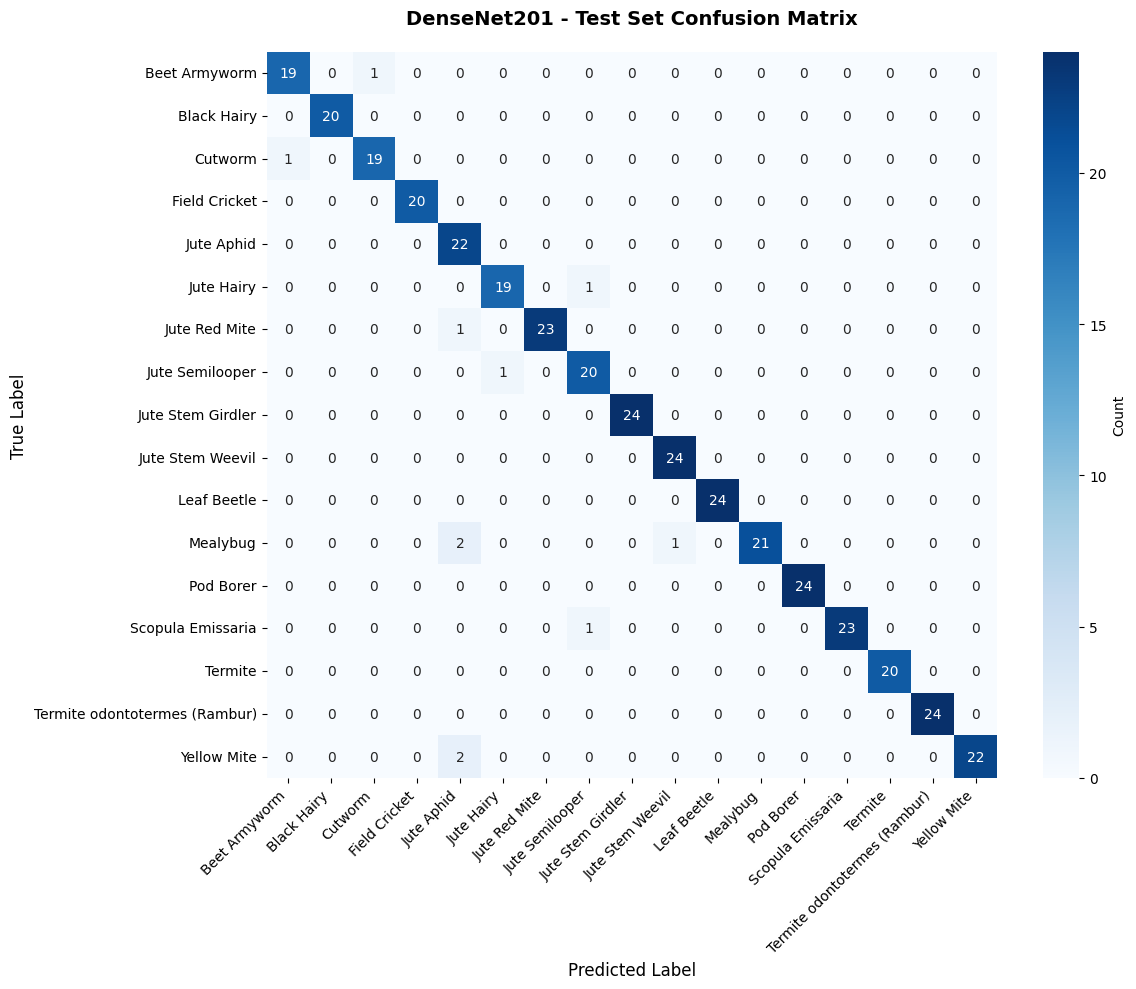

In [ ]:

print_evaluation_results(all_results['DenseNet201']['train'], 'DenseNet201', 'Training')
plot_confusion_matrix(
    all_results['DenseNet201']['train']['y_true'],
    all_results['DenseNet201']['train']['y_pred'],
    'DenseNet201', 'Training'
)


print_evaluation_results(all_results['DenseNet201']['val'], 'DenseNet201', 'Validation')
plot_confusion_matrix(
    all_results['DenseNet201']['val']['y_true'],
    all_results['DenseNet201']['val']['y_pred'],
    'DenseNet201', 'Validation'
)


print_evaluation_results(all_results['DenseNet201']['test'], 'DenseNet201', 'Test')
plot_confusion_matrix(
    all_results['DenseNet201']['test']['y_true'],
    all_results['DenseNet201']['test']['y_pred'],
    'DenseNet201', 'Test'
)

### Summary Comparison Table

In [ ]:
comparison_data = []

for model_name in model_names_list:
    for set_name in ['train', 'val', 'test']:
        metrics = all_results[model_name][set_name]
        comparison_data.append({
            'Model': model_name,
            'Dataset': set_name.capitalize(),
            'Accuracy': f"{metrics['accuracy']:.4f}",
            'Precision': f"{metrics['precision']:.4f}",
            'Recall': f"{metrics['recall']:.4f}",
            'F1-Score': f"{metrics['f1_score']:.4f}",
            'AUC': f"{metrics['auc']:.4f}"
        })

df_comparison = pd.DataFrame(comparison_data)



print('MODEL PERFORMANCE COMPARISON - ALL METRICS')
print(df_comparison.to_string(index=False))

MODEL PERFORMANCE COMPARISON - ALL METRICS
         Model Dataset Accuracy Precision Recall F1-Score    AUC
      ResNet50   Train   0.9936    0.9937 0.9936   0.9936 1.0000
      ResNet50     Val   0.9775    0.9779 0.9775   0.9774 0.9996
      ResNet50    Test   0.9736    0.9755 0.9736   0.9737 0.9997
     ResNet101   Train   0.9942    0.9942 0.9942   0.9942 1.0000
     ResNet101     Val   0.9790    0.9794 0.9790   0.9788 0.9998
     ResNet101    Test   0.9710    0.9740 0.9710   0.9707 0.9997
EfficientNetB0   Train   0.9919    0.9920 0.9919   0.9919 1.0000
EfficientNetB0     Val   0.9837    0.9840 0.9837   0.9837 0.9997
EfficientNetB0    Test   0.9736    0.9774 0.9736   0.9741 0.9999
         VGG16   Train   0.9913    0.9914 0.9913   0.9913 1.0000
         VGG16     Val   0.9736    0.9739 0.9736   0.9734 0.9994
         VGG16    Test   0.9736    0.9739 0.9736   0.9732 0.9997
   DenseNet201   Train   0.9952    0.9953 0.9952   0.9952 1.0000
   DenseNet201     Val   0.9837    0.9840 0.983

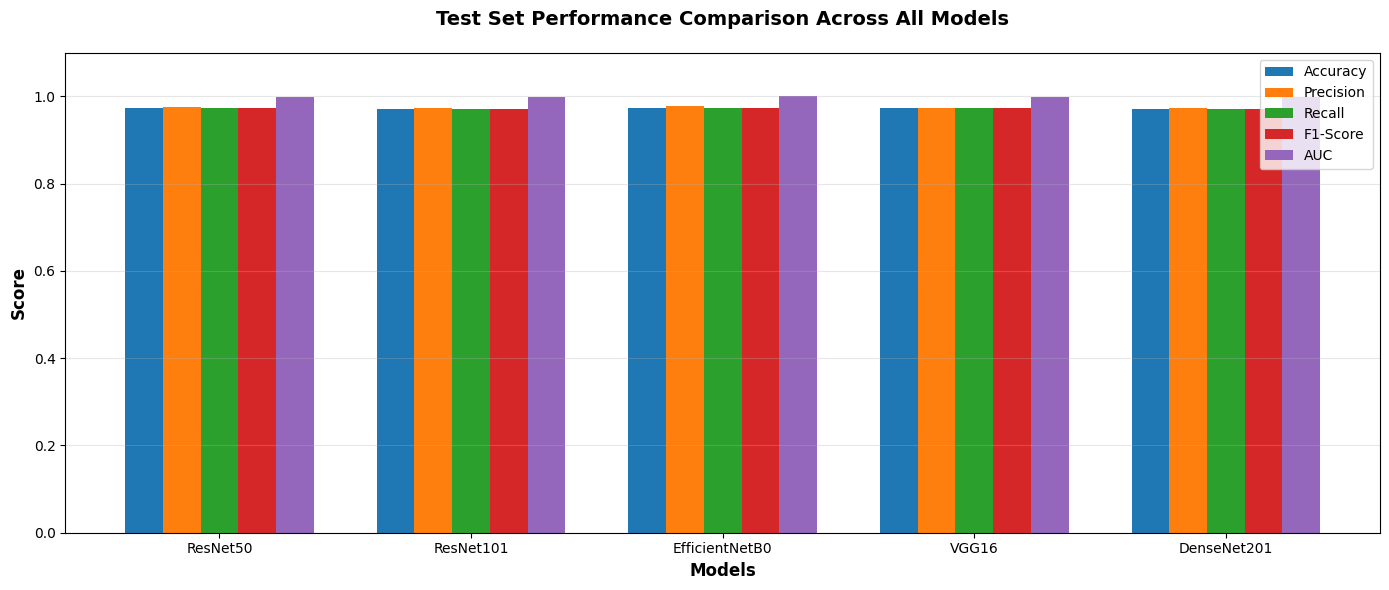

In [ ]:

test_comparison = df_comparison[df_comparison['Dataset'] == 'Test'].copy()


metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
for metric in metrics_to_plot:
    test_comparison[metric] = test_comparison[metric].astype(float)


fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(model_names_list))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    values = [test_comparison[test_comparison['Model'] == model][metric].values[0]
              for model in model_names_list]
    ax.bar(x + i*width, values, width, label=metric)

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Test Set Performance Comparison Across All Models',
            fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x + width * 2)
ax.set_xticklabels(model_names_list, rotation=0)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'test_performance_comparison.png'),
            dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
best_model_info = {}
best_f1 = 0


print('RESULTS OF PERFORMANCE OF THE MODELS ON TEST SET')

for model_name in model_names_list:
    test_metrics = all_results[model_name]['test']
    print(f"\n{model_name}:")
    print(f"  Test F1-Score: {test_metrics['f1_score']:.4f}")
    print(f"  Test AUC: {test_metrics['auc']:.4f}")
    print(f"  Test Accuracy: {test_metrics['accuracy']:.4f}")

    if test_metrics['f1_score'] > best_f1:
        best_f1 = test_metrics['f1_score']
        best_model_info = {
            'name': model_name,
            'f1': test_metrics['f1_score'],
            'auc': test_metrics['auc'],
            'accuracy': test_metrics['accuracy'],
            'precision': test_metrics['precision'],
            'recall': test_metrics['recall']
        }


print(f"BEST PERFORMING MODEL: {best_model_info['name']}")

print(f"Test Accuracy:  {best_model_info['accuracy']:.4f}")
print(f"Test Precision: {best_model_info['precision']:.4f}")
print(f"Test Recall:    {best_model_info['recall']:.4f}")
print(f"Test F1-Score:  {best_model_info['f1']:.4f}")
print(f"Test AUC:       {best_model_info['auc']:.4f}")


with open(os.path.join(RESULTS_PATH, 'best_model_info.txt'), 'w') as f:
    f.write(f"Best Model: {best_model_info['name']}\n")
    f.write(f"Test Accuracy: {best_model_info['accuracy']:.4f}\n")
    f.write(f"Test Precision: {best_model_info['precision']:.4f}\n")
    f.write(f"Test Recall: {best_model_info['recall']:.4f}\n")
    f.write(f"Test F1-Score: {best_model_info['f1']:.4f}\n")
    f.write(f"Test AUC: {best_model_info['auc']:.4f}\n")

RESULTS OF PERFORMANCE OF THE MODELS

ResNet50:
  Test F1-Score: 0.9737
  Test AUC: 0.9997
  Test Accuracy: 0.9736

ResNet101:
  Test F1-Score: 0.9707
  Test AUC: 0.9997
  Test Accuracy: 0.9710

EfficientNetB0:
  Test F1-Score: 0.9741
  Test AUC: 0.9999
  Test Accuracy: 0.9736

VGG16:
  Test F1-Score: 0.9732
  Test AUC: 0.9997
  Test Accuracy: 0.9736

DenseNet201:
  Test F1-Score: 0.9713
  Test AUC: 0.9996
  Test Accuracy: 0.9710
BEST PERFORMING MODEL: EfficientNetB0
Test Accuracy:  0.9736
Test Precision: 0.9774
Test Recall:    0.9736
Test F1-Score:  0.9741
Test AUC:       0.9999


## Analysis
## Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem


Based on the reported test results, we can observe the following:

*   All five transfer learning models perform strongly and comparably: ResNet50, ResNet101, EfficientNetB0, VGG16, and DenseNet201 all achieve test accuracies close to 97%, along with consistently high F1-scores and AUC values, demonstrating effective learning for the 17-class jute pest classification task
*   **EfficientNetB0 achieves the highest multi-class performance metrics**: Among the evaluated models, EfficientNetB0 attains the highest test F1-score (0.9741) and the highest AUC (0.9999), while maintaining test accuracy comparable to ResNet50 and VGG16.
*   F1-score and AUC are prioritized over accuracy: In this multi-class classification setting, I rely primarily on F1-score and AUC for model comparison, as these metrics provide a more informative assessment of performance when class frequencies may vary.
* No model overwhelmingly outperforms the others: While small performance differences exist among the models, these differences are marginal rather than decisive


### Inferences on Model Generalization based on Training and Validation Curves
Based on the training and validation curves, I observe that all models exhibit stable learning behavior and good generalization. This is supported by the following observations:
* Training and validation losses track each other closely: Throughout training, the validation loss follows the training loss without large fluctuations, indicating that the models learn meaningful features without memorizing the training data.
* Training and validation accuracy curves remain aligned: There is no sharp separation between the training and validation accuracy curves, suggesting that overfitting does not occur during training

### Conclusion
In conclusion, while EfficientNetB0 slightly outperforms the other models based on multi-class F1-score(0.9741) and AUC(0.9999). The performance differences across all five architectures are small.

## References



1. Batch Normalization: https://en.wikipedia.org/wiki/Batch_normalization
2. Transfer Learning Guide: https://builtin.com/data-science/transfer-learning
3. NumPy – https://numpy.org/

4. Matplotlib – https://matplotlib.org/
5. Keras Documentation: https://keras.io
6. TensorFlow – https://www.tensorflow.org/

7. Keras – https://keras.io/

8. scikit-learn – https://scikit-learn.org/

9. OpenCV – https://opencv.org/

10. ImageNet – https://www.image-net.org/

11. GPT Prompt: Show me how to freeze layers and attach the classification head with an example.
